In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"

In [2]:
%%capture
try:
    from pandas_datareader.fred import FredReader
except ImportError:
    !pip install pandas-datareader
    from pandas_datareader.fred import FredReader

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm

import gEconpy as ge
import gEconpy.plotting as gp

gp.set_matplotlib_style()

In [4]:
RANDOM_SEED = sum(map(ord, "USA RBC Estimation"))
rng = np.random.default_rng(RANDOM_SEED)

# Fitting an RBC to US Data

In this notebook, we go through steps to fit an RBC model to actual US data. This begins with grabbing data (in this case from FRED), doing some light preprocessing, then fitting the model using PyMC.

## Get US data

We want series for consumption, investment, labor, GDP, interest rate, and wages

In [5]:
indicators = {
    "NAEXKP01USQ652S": "Y",  # GDP
    "NAEXKP04USQ652S": "I",  # Investment
    "NAEXKP02USQ189S": "C",  # HH consumption
    "TOTLQ": "L",  # total non-farm hours worked
    "GS10": "i",  # 10-year interest rate
    "CES0500000003": "w",  # average hourly wage
    "CPIAUCSL": "cpi",  # CPI
}

if not os.path.isfile("us_fred_data.csv"):
    data = FredReader(symbols=list(indicators.keys()), start="1900", end=None).read()
    data.to_csv("us_fred_data.csv")
else:
    data = pd.read_csv(
        "us_fred_data.csv",
        index_col=0,
        parse_dates=["DATE"],
    )

## Raw Data from FRED

The first problem we encounter is different frequencies of data. We want everything to be quarterly, so step 1 is to convert everything.

Well, actually step 1 is to rename these awful columns.

In [6]:
data.tail(10)

NAEXKP01USQ652S  NAEXKP04USQ652S  NAEXKP02USQ189S  TOTLQ  GS10  \
DATE                                                                         
2024-05-01              NaN              NaN              NaN    NaN  4.48   
2024-06-01              NaN              NaN              NaN    NaN  4.31   
2024-07-01              NaN              NaN              NaN    NaN  4.25   
2024-08-01              NaN              NaN              NaN    NaN  3.87   
2024-09-01              NaN              NaN              NaN    NaN  3.72   
2024-10-01              NaN              NaN              NaN    NaN  4.10   
2024-11-01              NaN              NaN              NaN    NaN  4.36   
2024-12-01              NaN              NaN              NaN    NaN  4.39   
2025-01-01              NaN              NaN              NaN    NaN  4.63   
2025-02-01              NaN              NaN              NaN    NaN  4.45   

            CES0500000003  CPIAUCSL  
DATE                                 
2024-05-01          34.89   313.140  
2024-06-01          35.00   313.131  
2024-07-01          35.07   313.566  
2024-08-01          35.23   314.131  
2024-09-01          35.33   314.851  
2024-10-01          35.48   315.564  
2024-11-01          35.61   316.449  
2024-12-01          35.68   317.603  
2025-01-01          35.83   319.086  
2025-02-01          35.93   319.775

In [7]:
df = data.rename(columns=indicators)
df.index.name = "Time"

Ok, much nicer. 

Y, C, I and L are already quarterly, so we can use those as-is. We have to aggregate $r$ and $w$. One has to be careful when doing this, because flow variables and stock variables are aggregated diffrently. Specifically, one has to take the sum for flow variables, and use the first or last observation for stock variables (which one you pick is determined by the timing convention you're using)

$w$ is average hourly wages. This is actually a stock variable, as are most prices (convince yourself that the price of a stock isn't a function of how long you watch a chart -- the price is simply the most recent number!)

For convenience, we take the rental rate of capital to be the real interest rate. The 10-year treasure rate is something like a nominal interest rate, so to get the real rate out of that we use the Fisher equation:

$$ (1 + i) = (1 + r)(1 + \pi) $$

Solving for $r$:

$$ r = \frac{1 + i}{1 + \pi} - 1 $$

In [8]:
# These 3 columns are already quarterly, so it doesn't matter if we take first or last
df_YICL = df[["Y", "I", "C", "L"]].resample("QS-OCT").last()
df_YICL_2 = df[["Y", "I", "C", "L"]].resample("QS-OCT").first()

# Just a sanity check that there's only one value per quarter. If there isn't, first and last won't be equal.
pd.testing.assert_frame_equal(df_YICL, df_YICL_2)

# Here we have to make a timing choice. We will consider a row of data to represent the *end* of the quarter,
# not the beginning
df_w = df[["w"]].resample("QS-OCT").last()

# Need to adjust wages for inflation, since all price variables in the model are real. For this, divide through
# by the CPI and multiply by 100
# To convert CPI from monthly to quarterly, take the last month value of each quarter (stock variable)
df_w = (
    df_w / df.cpi.resample("QS-OCT").last().reindex_like(df_w).values[:, None]
) * 100

In [9]:
pi = df.cpi.pct_change(fill_method=None)
r = (df.i.mul(1e-2).add(1) / pi.add(1) - 1).to_frame(name="r").dropna()

In [10]:
def compound(r):
    return r.add(1).prod().pow(1 / 3) - 1


df_r = r.resample("QS-OCT").apply(compound).mul(1e2)

In [11]:
df = df_YICL.join(df_w).join(df_r)

Data are now all quarterly! We confirm it by looking at the table, but we can also look at the frequency of the index

In [12]:
df.tail()

Y   I   C   L          w         r
Time                                           
2024-01-01 NaN NaN NaN NaN  11.108370  3.783503
2024-04-01 NaN NaN NaN NaN  11.177431  4.329314
2024-07-01 NaN NaN NaN NaN  11.221181  3.756799
2024-10-01 NaN NaN NaN NaN  11.234151  3.981176
2025-01-01 NaN NaN NaN NaN  11.236025  2.770449

In [13]:
df.index.freq = df.index.inferred_freq
df.index.freq

<QuarterBegin: startingMonth=10>

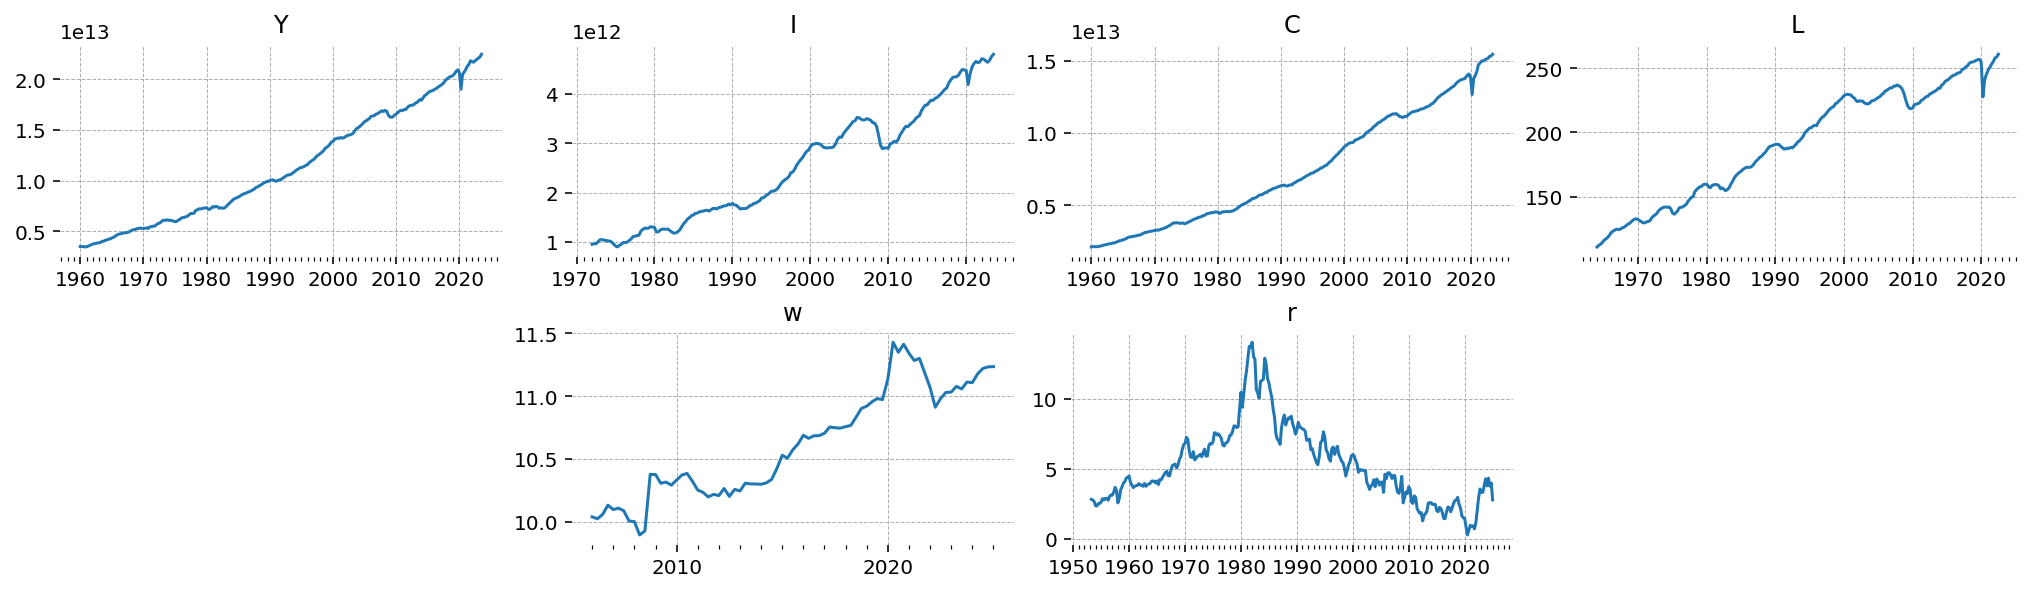

In [14]:
gp.plot_timeseries(df);

## Preprocessing

These all need to be logged and de-trended. I'll use an OLS regression to remove the trend. Interest rates are already a percentage, so they don't need to be logged. They do need to be converted to decimal, though.

All the series are seasonally adjusted and in constant chained dollars. Actually I don't know if this is correct. It might be more correct to use raw series. There's no prices in this model so I don't think it matters, but in a full New Keynesian model with a monetary authority it might be correct to use unadjusted data.

[Pfeifer (2013)](https://drive.google.com/file/d/1r89OU5OE3CBa6tOlj6l3hNVWEaRH5Anv/view) is an excellent resource for data preprocessing and common issues that one will encounter when preparing macro timeseries to estimation in a DSGE model.

In [15]:
X = np.c_[np.ones(df.shape[0]), np.arange(df.shape[0]), np.arange(df.shape[0]) ** 2]
betas = {}

df_detrend = df.copy()

for col in df:
    if col == "r":
        df_detrend[col] = df[col].mul(1e-2).add(1)
        r_mean = df_detrend[col].mean()
        df_detrend[col] = df_detrend[col] - r_mean
        betas[col] = np.r_[r_mean, 0, 0]
        continue
    y = np.log(df_detrend[col])
    not_na = y.notna().values
    X_valid = X[not_na, :]
    beta = np.linalg.inv(X_valid.T @ X_valid) @ X_valid.T @ y.dropna()
    betas[col] = beta
    trend = X_valid @ beta
    resid = y.dropna() - trend
    df_detrend.loc[not_na, col] = resid


# Drop quarters where we don't observe at least 2 of Y, C, or I.
df_detrend.dropna(thresh=2, subset=["Y", "C", "I"], inplace=True)

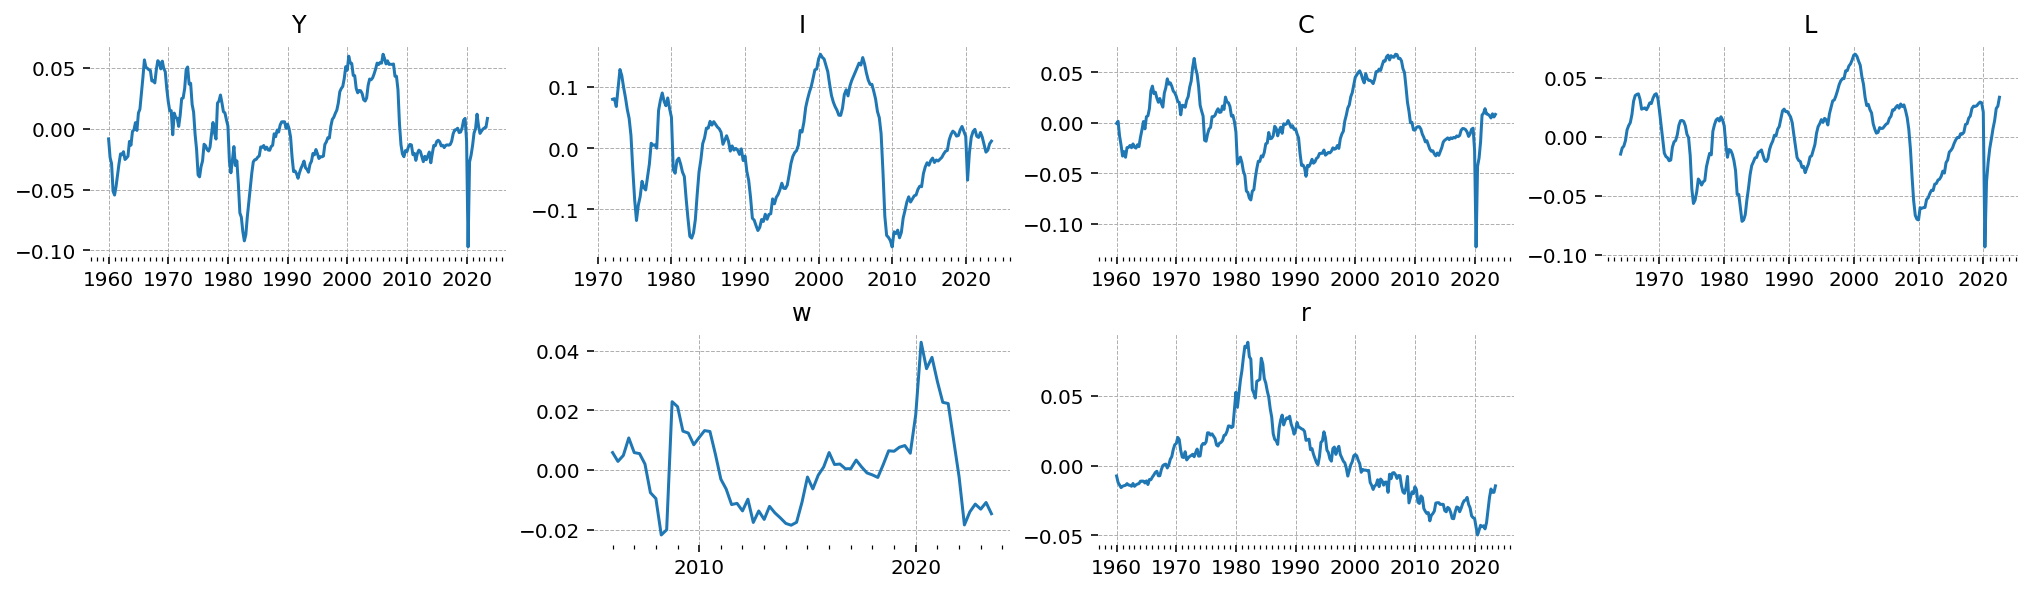

In [16]:
gp.plot_timeseries(df_detrend);

# Estimation with PyMC

Currently all model construction for gEconpy is done via GCN files. You can check the model definition of a given file by using the `print_gcn_file` function

In [17]:
file_path = "../GCN Files/RBC.gcn"
ge.print_gcn_file(file_path)

Once we're satisfied with the model we're going to estimate, we create a `PyMCStateSpace` object using `ge.statespace_from_gcn`

In [18]:
ss_mod = ge.statespace_from_gcn(file_path)

Model Building Complete.
Found:
	9 equations
	9 variables
		The following variables were eliminated at user request:
			TC_t, U_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 6 / 6 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



Statespace model construction complete, but call the .configure method to finalize.


## Prior Selection

Looking at the build report, we see that 6 parameters already have priors defined in the GCN. We can see these using `gp.plot_priors`

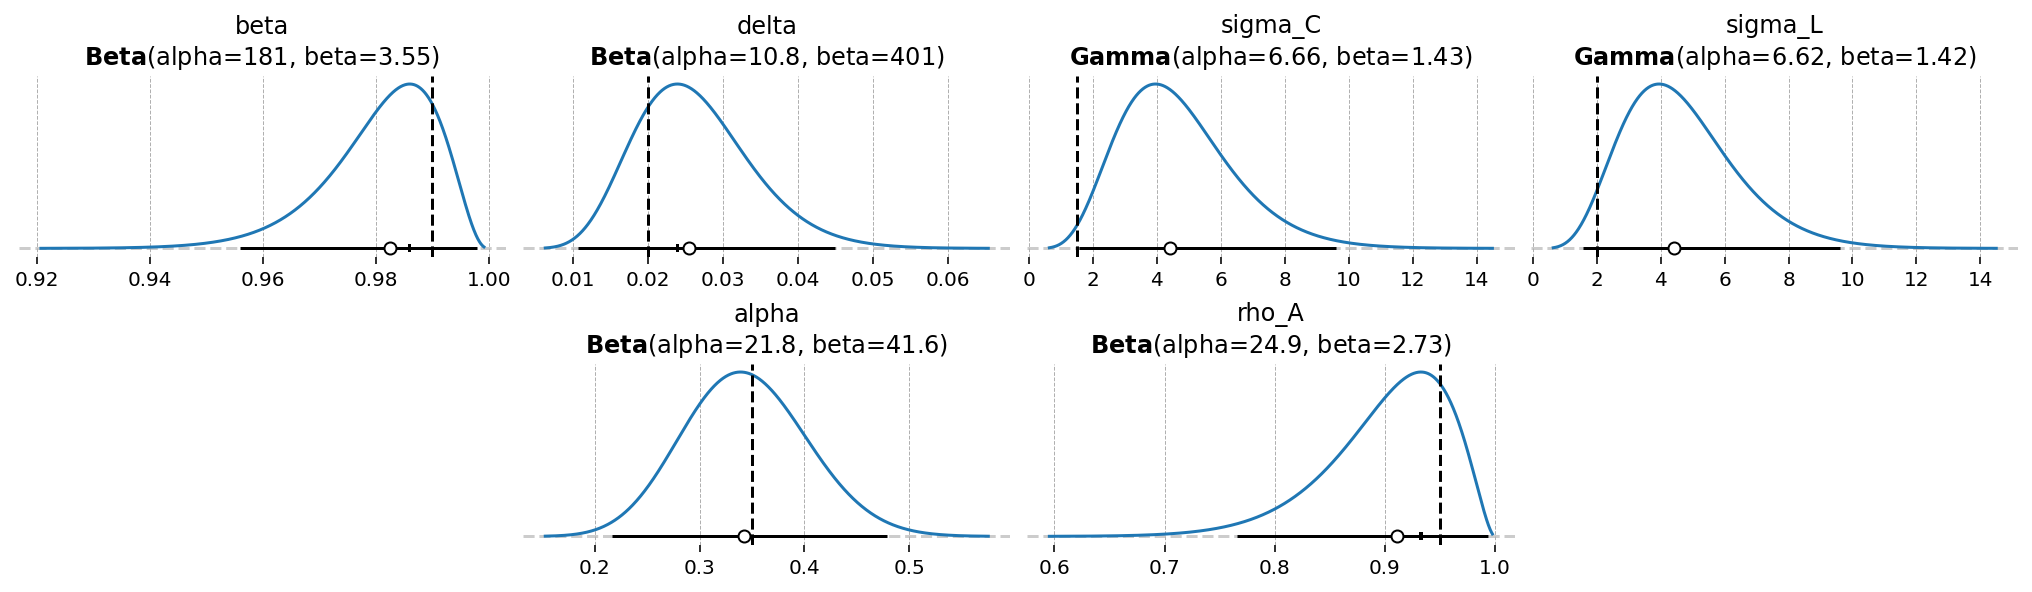

In [19]:
gp.plot_priors(ss_mod, n_cols=4, figsize=(14, 4));

It also says that we're missing a prior on the shock. These are always called `sigma_{shock_name}`. Keep this in mind, because we will have to define it manually in a PyMC model.

In [20]:
# Save this for later
prior_dict = ss_mod.param_priors.copy()

## Model Configuration

To set up a statespace model, you first have to call the `.configure` method. This finalizes model settings, by allowing you to choose:

- `observed_states`: Which states in the DSGE model are observed 
- `measurement_error`: Which observed states have associated measurement error
- `full_shock_covariance`: Whether to estimate a full shock covariance matrix, or just the diagonal elements
- `mode`: Which computational backend to compile the model `logp` function to. See the pytensor documentation for details about the choices. `mode="JAX"` is strongly recommended.
- `solver`: Which algorithm to use for finding the linear policy function. Choices are `gensys`, `cycle_reduction`, or `scan_cycle_reduction`. Only `scan_cycle_reduction` is supported when `mode="JAX"`.
- `use_adjoint_gradients`: Whether to autodiff through the `cycle_reduction` algorithm (`False`), or to directly use an analytical solution (`True`). The analytical solution is recommended.
- `max_iter`: The maximum number of iterations allowed to the `cycle_reduction` algorithm. Because of how looping works in autodiff, loops must always run for the maximum number of iterators. If convregence is detected before the maximum iteration, computation is replaced with the identity function, but it's still not "free". Thus, a low number (10-20), is recommended here to maximimze performance.

Recall that you are only allowed to have as many observed variables in a model as you have sources of stochastic variation. We have one shock in the model, so to include more variables, we will need to add measurement error. 

In [21]:
ss_mod.configure(
    observed_states=df.columns,
    measurement_error=df.columns,
    mode="JAX",
    solver="scan_cycle_reduction",
    use_adjoint_gradients=True,
    max_iter=20,
)

                  Model Requirements                  
                                                      
  Variable          Shape   Constraints   Dimensions  
 ──────────────────────────────────────────────────── 
  alpha             ()                          None  
  beta              ()                          None  
  delta             ()                          None  
  rho_A             ()                          None  
  sigma_C           ()      Positive            None  
  sigma_L           ()      Positive            None  
  sigma_epsilon_A   ()      Positive            None  
  error_sigma_Y     ()                          None  
  error_sigma_I     ()                          None  
  error_sigma_C     ()                          None  
  error_sigma_L     ()                          None  
  error_sigma_w     ()                          None  
  error_sigma_r     ()                          None  
                                                      
 These parameters should be assigned priors inside a  
         PyMC model block before calling the          
            build_statespace_graph method.            

In [22]:
# Save some groups of variable names for later
all_params = ss_mod.param_names
deep_params = list(ss_mod.param_dict.keys())
shock_params = [f"sigma_{name}" for name in ss_mod.shock_names]
error_params = [f"error_sigma_{name}" for name in ss_mod.error_states]

## Building PyMC model

The `Model Requirements` table tells us what we need to define. We already have priors for the 6 deep parameters. These can be quickly added using `ss_mod.to_pymc()`. Then we have to define the remaining standard deviations: `sigma_epsilon_A`, `error_sigma_Y`, `error_sigma_I`, `error_sigma_C`, `error_sigma_w`, and `error_sigma_r`. 

The model is log-linearized, so all values are in percentage deviation from steady state. This is nice, because we can think about the errors in percentage terms. We can assume a prior that data are at most 5% off, which implies a standard deviation of at most ~5 (2 * sqrt(5) = 4.47, just round back up to 5). 

Probably that huge, but why not. It's just a prior!

In [23]:
with pm.Model(coords=ss_mod.coords) as usa_rbc:
    ss_mod.to_pymc()

    # Save the pre-defined priors as a variable we can use to stay organized
    prior_dict = ss_mod.param_priors.copy()

    # pz.maxent helps us by finding the distribution in a given family with some percent of total mass between
    # two points. Technically infinity distribtuions will satisfy that criteria, so it gives the one with
    # maximum entropy. It's much easier to reason about ranges of admissible values than parameters.

    prior_dict["sigma_epsilon_A"] = pz.maxent(
        pz.Gamma(), lower=0.01, upper=0.1, plot=False
    )
    prior_dict["sigma_epsilon_A"].to_pymc("sigma_epsilon_A")

    # As mentioned above, we'll make the measurement errors between 0% and 5%
    for var in ss_mod.error_states:
        d = pz.maxent(pz.Gamma(), lower=0.001, upper=0.05, plot=False)
        prior_dict[f"error_sigma_{var}"] = d
        d.to_pymc(f"error_sigma_{var}")

    ss_mod.build_statespace_graph(
        data=df_detrend[ss_mod.observed_states],
        add_norm_check=True,
        add_solver_success_check=True,
        add_steady_state_penalty=True,
    )

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


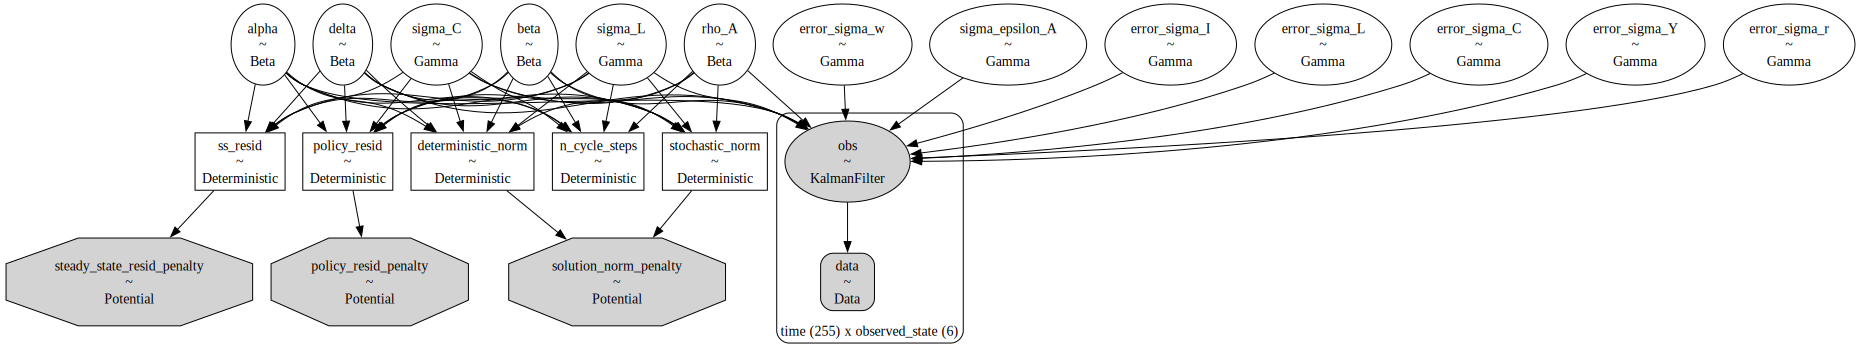

In [24]:
usa_rbc.to_graphviz()

## Estimation Methods

PyMC offers a huge variety of ways to estimate a model. To see a comparison between some of these, see the {ref}`Estimation Example notebook <wrapping_jax_function>`. Here, we will just use NUTS, which is the recommended method to fit a Bayesian model. By using gradient information about the likelihood function, it offers extremely effecient sampling. Chains can be much shorter, and no thinning is required!

We will sample with nutpie's experimental Fisher Adaptive HMC, which embeds and trains a netural network to help learn about the complex posterior geometry characteristic of a DSGE model. 

In [25]:
import nutpie as ntp

ntp_mod = ntp.compile_pymc_model(
    usa_rbc,
    backend="jax",
    gradient_backend="jax",
    freeze_model=True,
    initial_points=ss_mod.param_dict,
)

idata = ntp.sample(
    ntp_mod.with_transform_adapt(verbose=False),
    chains=6,
    draws=500,
    tune=500,
    transform_adapt=True,
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


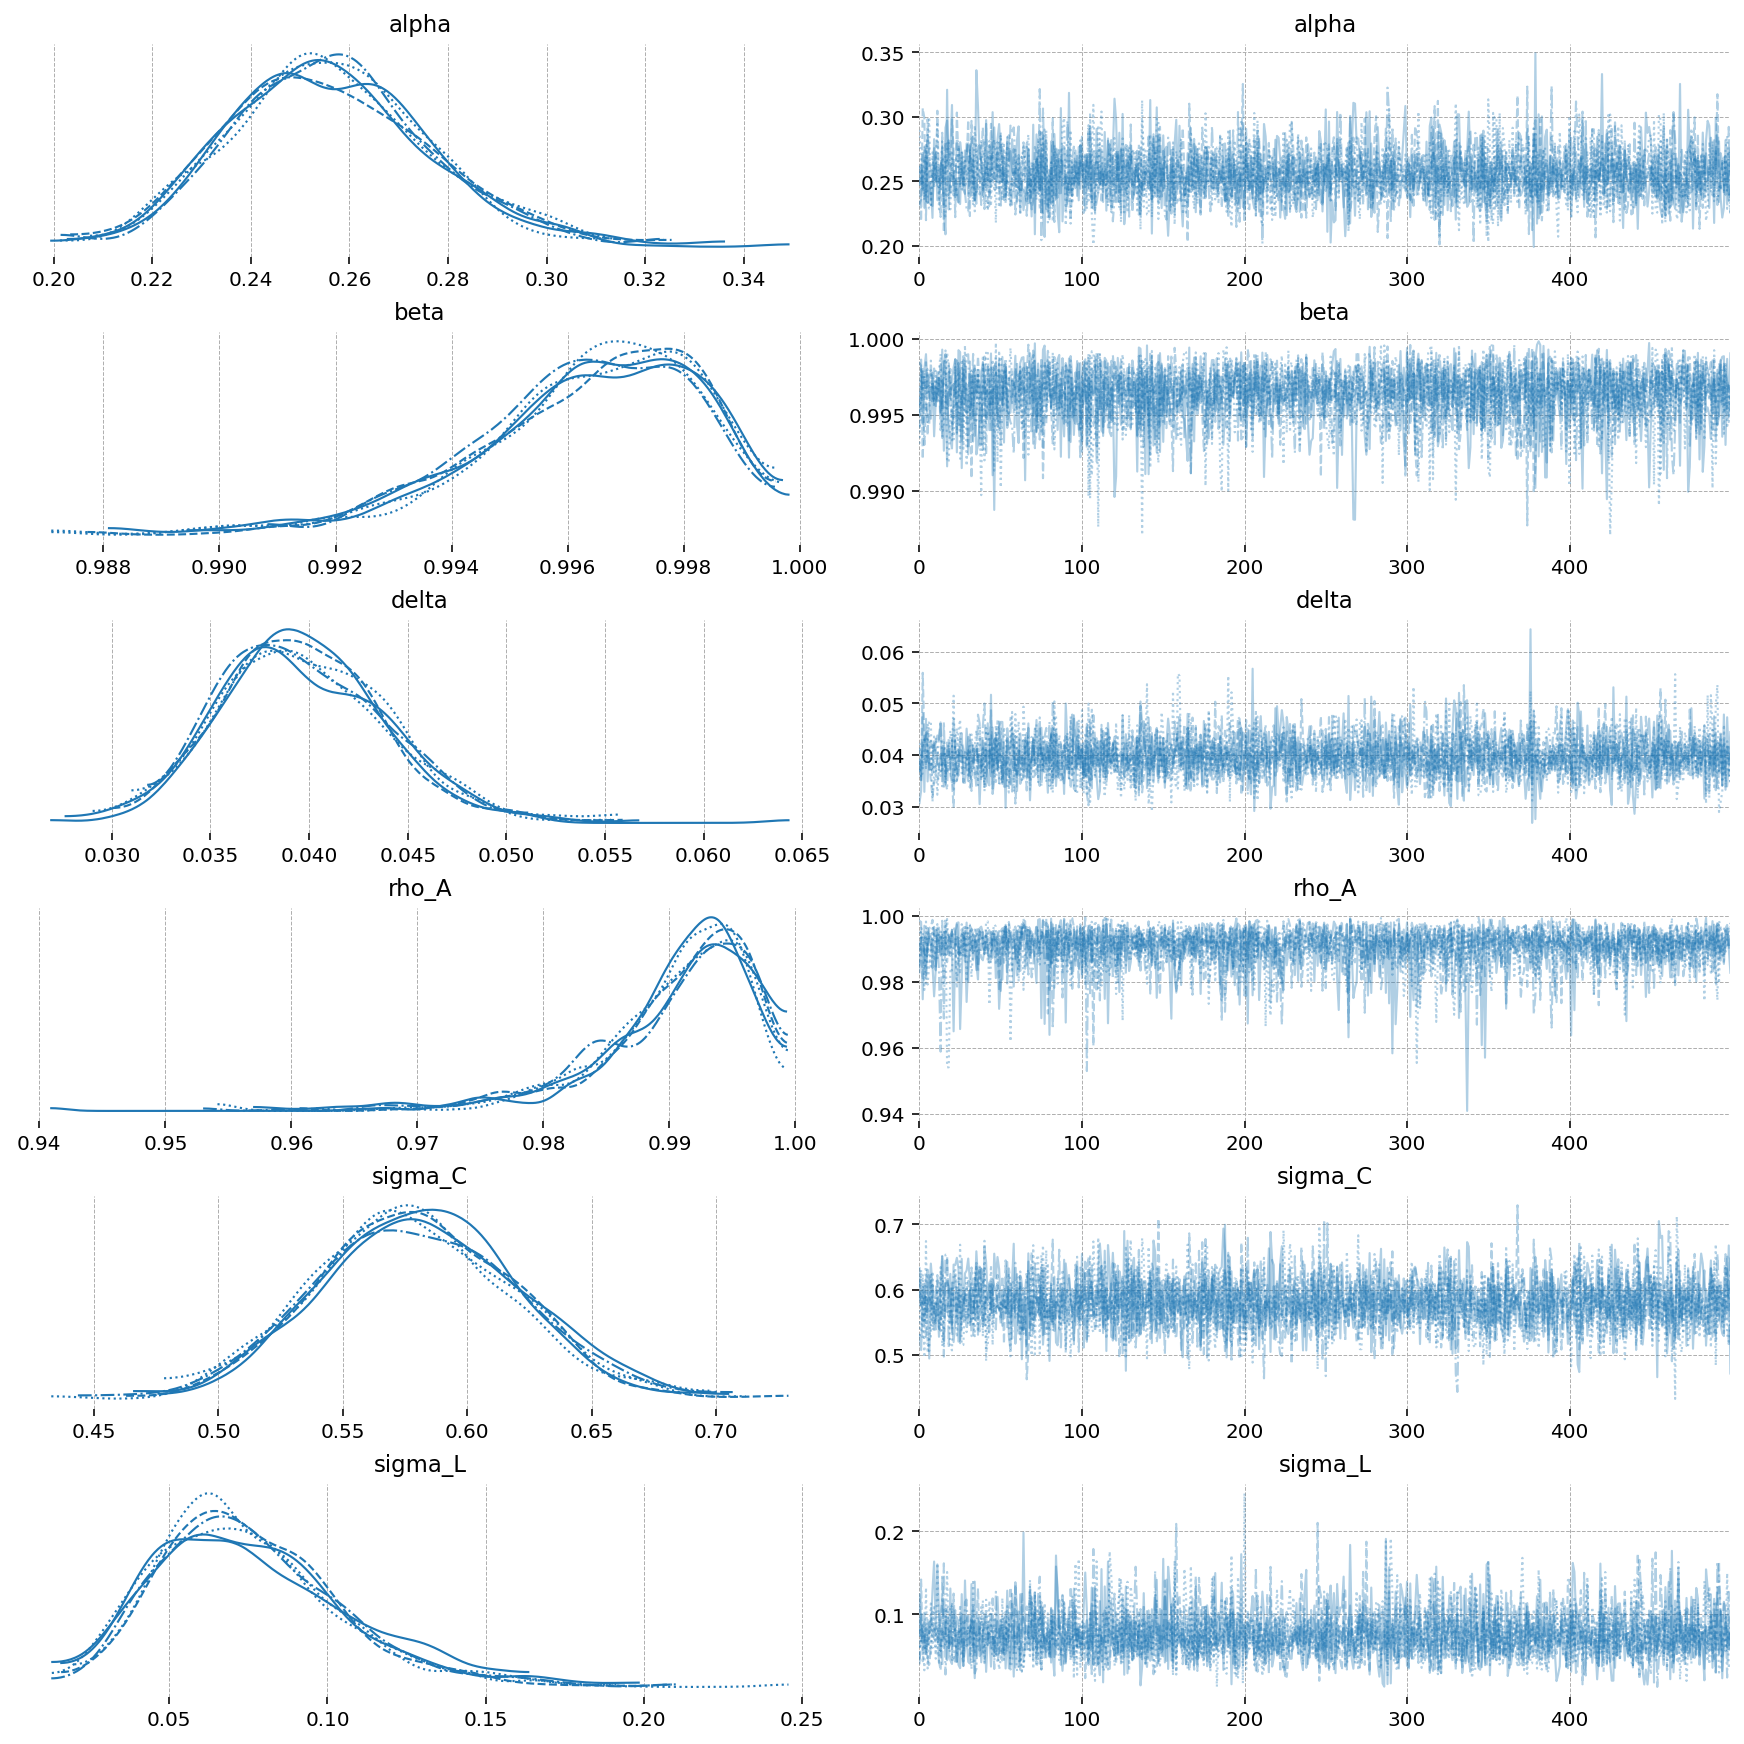

In [26]:
az.plot_trace(idata, var_names=deep_params);

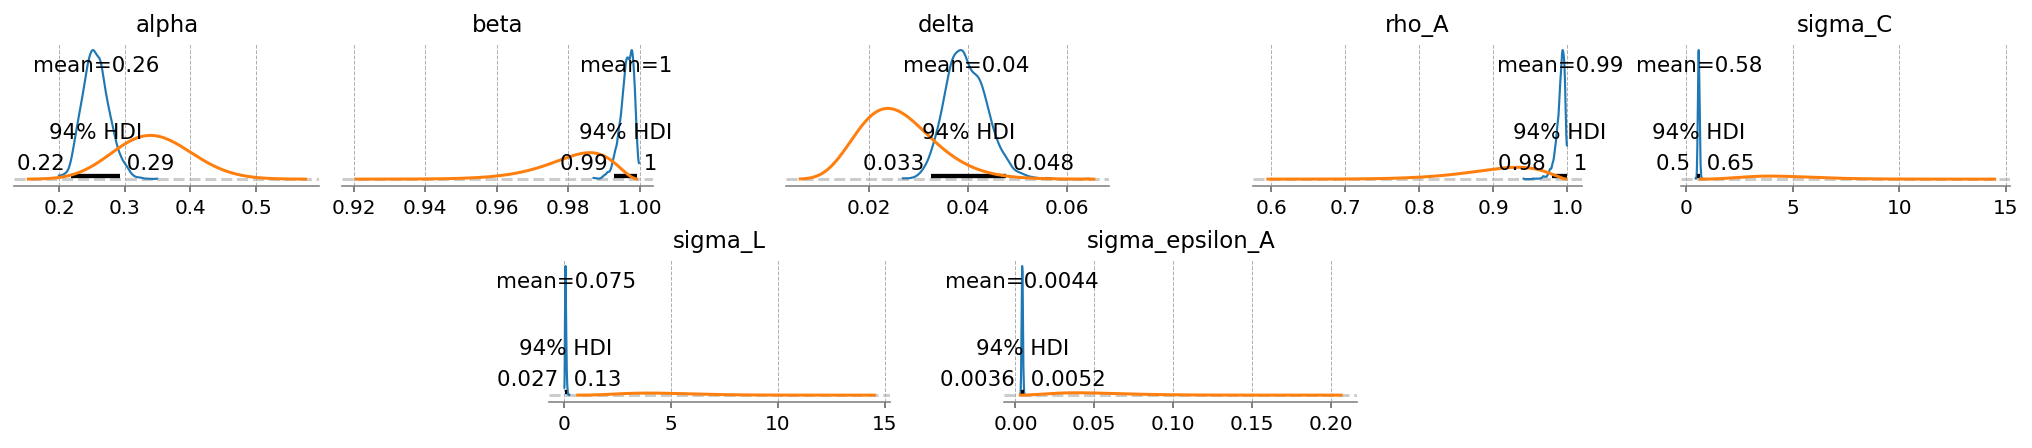

In [27]:
gp.plot_posterior_with_prior(
    idata, var_names=deep_params + shock_params, prior_dict=prior_dict
);

In a Kalman Filter, errors are used to gague how much an incoming time series should be "trusted" when performing a Bayesian update. Series that are judged to match the model dynamics poorly are thus assigned higher errors.

Here, we can see that $Y$ has a very low error. The model learned to focus on the GDP time series. $C$ is the next lowest. 

After that, $I$, $w$, and $r$ have about the same errors. In relative terms, the model is more or less learning to ignore these series.

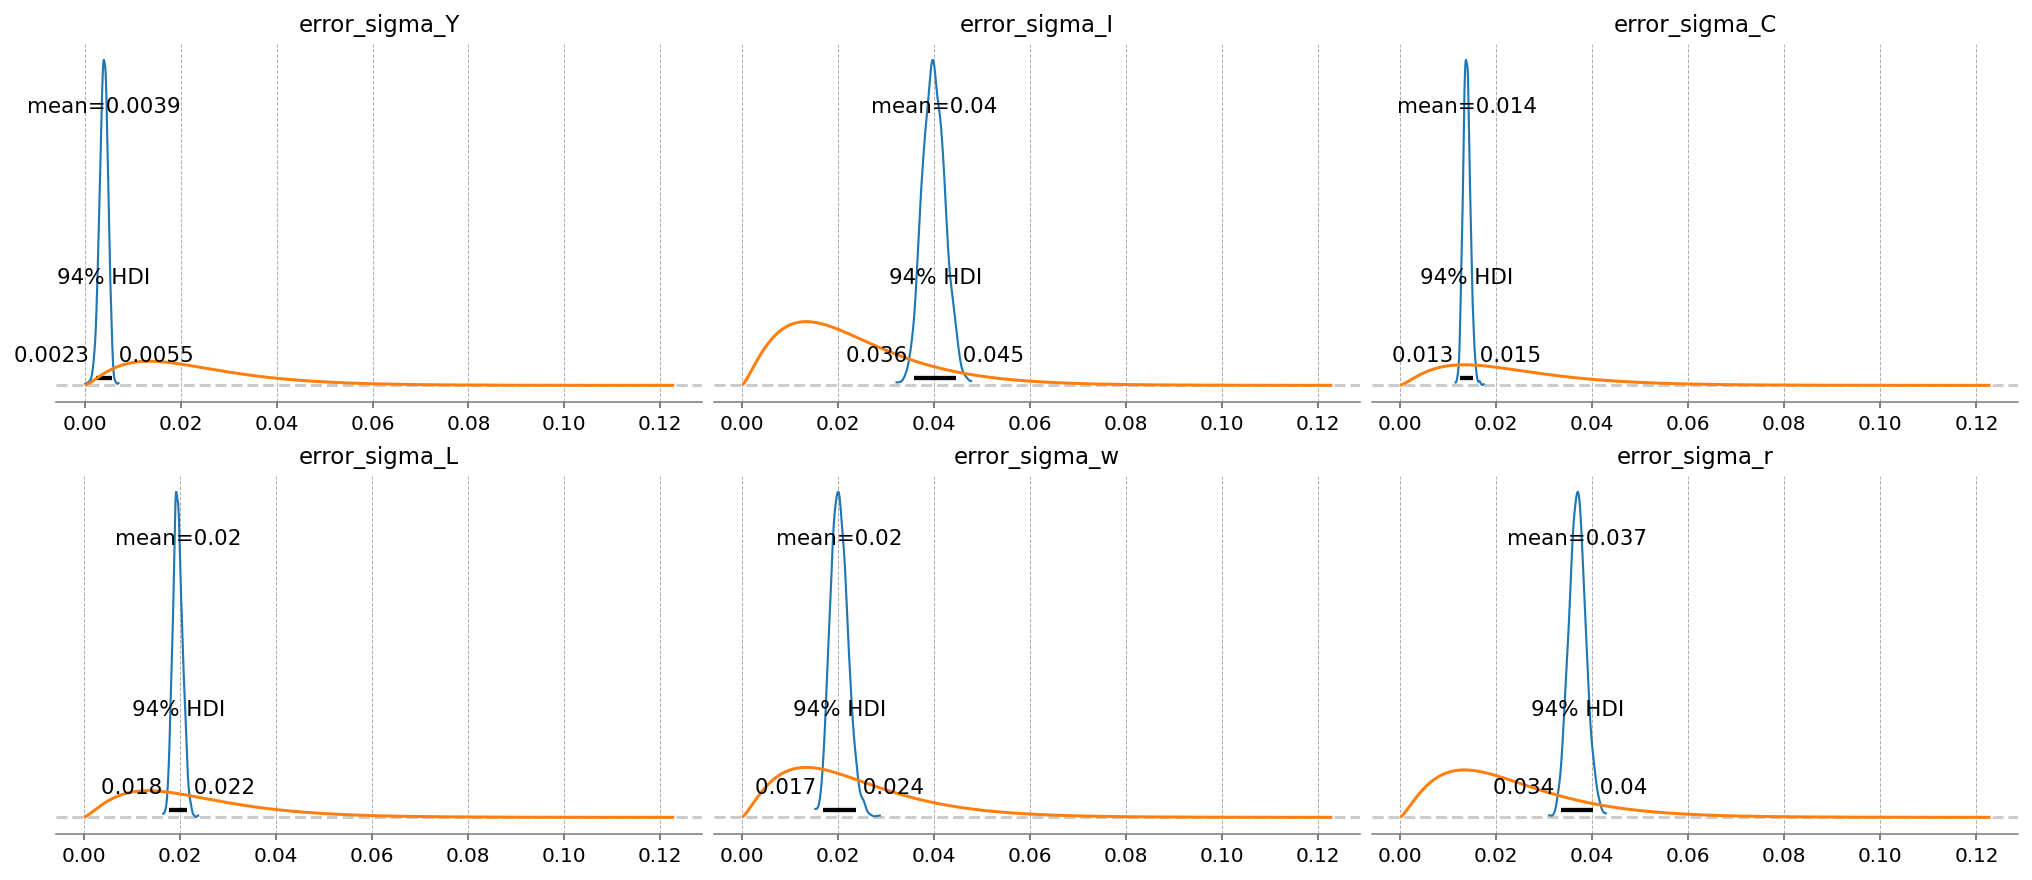

In [28]:
gp.plot_posterior_with_prior(
    idata, var_names=error_params, prior_dict=prior_dict, n_cols=3
);

In [29]:
latent_states = ss_mod.sample_conditional_posterior(idata, random_seed=rng)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F815CE40>), RNG(<Generator(PCG64) at 0x7F815CD60>), RNG(<Generator(PCG64) at 0x7F815CC80>), RNG(<Generator(PCG64) at 0x7F815CBA0>), RNG(<Generator(PCG64) at 0x7F815CAC0>), RNG(<Generator(PCG64) at 0x7F9135000>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(


Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

This model is not rich enough to capture all of the dynamics happening in the various time series. As we saw in the error posteriors, it learned to focus on $Y$, then $C$. We can see this in teh outputs. The learned dynamics match $Y$ very closely, and the model used the latent TFP shocks to explain $Y$. Notice the similarity between $A$ and $Y$! 

$C$ also matches closely, but we can see that the model is willing to make compromises away from the data (in order to do a better job explaing GDP, in this case). $I$ is similarly sacrificed. $r$ and $w$ are essentially hopeless; the model dynamics do not matched the observed data, and the filter used errors to essentially give up on them.

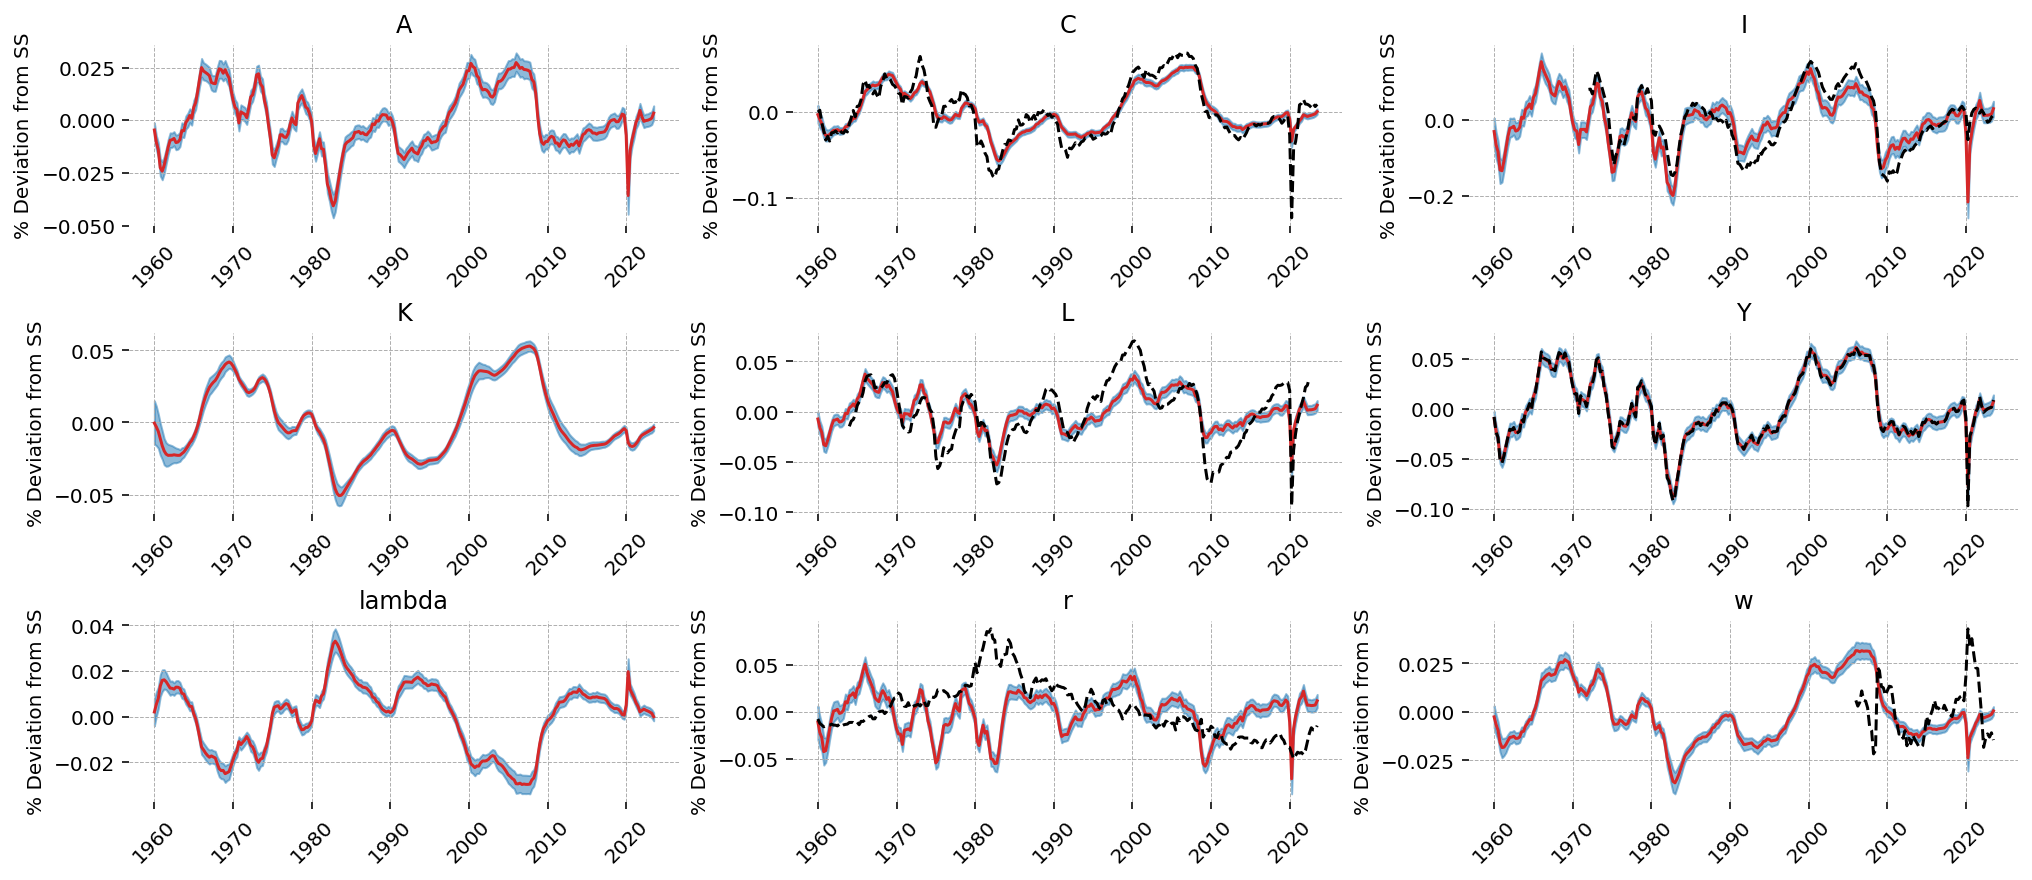

In [30]:
gp.plot_kalman_filter(
    idata=latent_states, data=df_detrend, kalman_output="smoothed", n_cols=3
);

# A Richer Model

It would be interesting to see if a richer model can do a better job explaning the data. `RBC_extended.gcn` adds the following features:

- Households now have habit formation -- $C_t - \phi_H C_{t-1}$ appears in the utility function

- Households now have a dispreference parameter on the labor dispreference term: $\Theta \frac{L_t^{1+\sigma_L}}{1+\sigma_L}$

- There is an investment friction term added that punishes households for changing the size of their investment allocation between periods

- Households choose intensitiy of capital utilization -- when higher, capital depreciates faster ($z_t$)

- Time varying household discount factor ($\beta$)

- Time varying household dispreference for labor ($\Theta$)

- The investment friction penalty is also time varying ($\text{shock}_{I,t}$)

You can click around in the following blocks to see the new equations.

In [31]:
gcn_rbc_extended = "../GCN Files/RBC_extended.gcn"
ge.print_gcn_file(gcn_rbc_extended)

In [32]:
ss_mod_extended = ge.statespace_from_gcn(gcn_rbc_extended)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/preliz/distributions/beta.py:135: RuntimeWarning: invalid value encountered in scalar divide
  self.nu = self.mu * (1 - self.mu) / self.sigma**2 - 1


Model Building Complete.
Found:
	14 equations
	14 variables
		The following variables were eliminated at user request:
			K_d_t, TC_t, U_t
		The following "variables" were defined as constants and have been substituted away:
			mc_t
	4 stochastic shocks
		 0 / 4 has a defined prior. 
	13 parameters
		 13 / 13 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



Statespace model construction complete, but call the .configure method to finalize.


In [33]:
ss_mod_extended.configure(
    observed_states=df_detrend.columns,
    measurement_error=df_detrend.columns,
    mode="JAX",
    solver="scan_cycle_reduction",
    use_adjoint_gradients=True,
    max_iter=20,
)

                    Model Requirements                    
                                                          
  Variable              Shape   Constraints   Dimensions  
 ──────────────────────────────────────────────────────── 
  Theta                 ()                          None  
  alpha                 ()                          None  
  beta                  ()                          None  
  delta                 ()                          None  
  gamma_I               ()                          None  
  phi_H                 ()                          None  
  psi_z                 ()                          None  
  rho_A                 ()                          None  
  rho_I                 ()                          None  
  rho_Theta             ()                          None  
  rho_beta              ()                          None  
  sigma_C               ()      Positive            None  
  sigma_L               ()      Positive            None  
  sigma_epsilon_A       ()      Positive            None  
  sigma_epsilon_I       ()      Positive            None  
  sigma_epsilon_Theta   ()      Positive            None  
  sigma_epsilon_beta    ()      Positive            None  
  error_sigma_Y         ()                          None  
  error_sigma_I         ()                          None  
  error_sigma_C         ()                          None  
  error_sigma_L         ()                          None  
  error_sigma_w         ()                          None  
  error_sigma_r         ()                          None  
                                                          
 These parameters should be assigned priors inside a PyMC 
  model block before calling the build_statespace_graph   
                         method.                          

In [34]:
with pm.Model(coords=ss_mod_extended.coords) as usa_rbc_extended:
    ss_mod_extended.to_pymc()

    # Save the pre-defined priors as a variable we can use to stay organized
    prior_dict = ss_mod_extended.param_priors.copy()

    for shock in ss_mod_extended.shock_names:
        prior_dict[f"sigma_{shock}"] = pz.maxent(
            pz.Gamma(), lower=0.01, upper=0.1, plot=False
        )
        prior_dict[f"sigma_{shock}"].to_pymc(f"sigma_{shock}")

    # As mentioned above, we'll make the measurement errors between 0% and 5%
    for var in ss_mod_extended.error_states:
        d = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        prior_dict[f"error_sigma_{var}"] = d
        d.to_pymc(f"error_sigma_{var}")

    ss_mod_extended.build_statespace_graph(
        data=df_detrend[ss_mod_extended.observed_states],
        add_norm_check=True,
        add_solver_success_check=True,
        add_steady_state_penalty=True,
    )

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


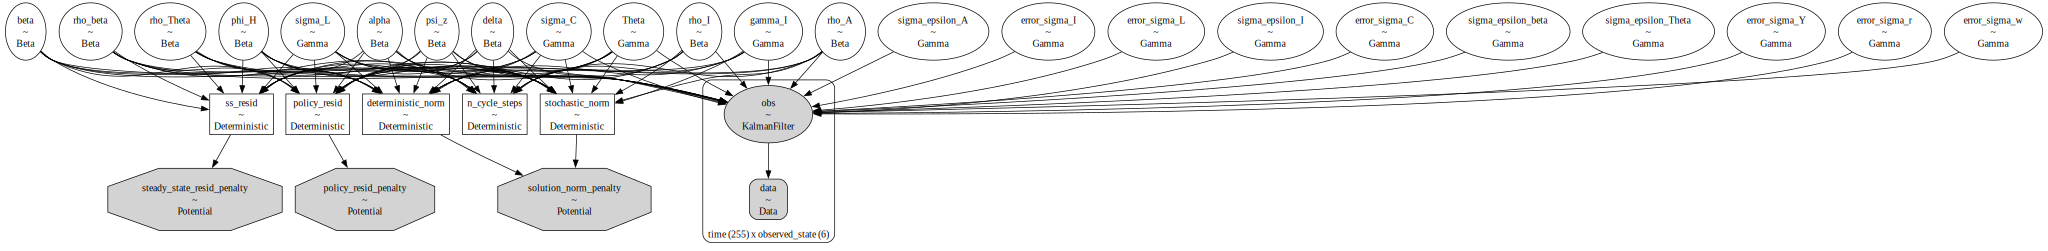

In [35]:
usa_rbc_extended.to_graphviz()

In [36]:
ntp_mod = ntp.compile_pymc_model(
    usa_rbc_extended,
    backend="jax",
    gradient_backend="jax",
    freeze_model=True,
    initial_points=ss_mod_extended.param_dict,
)

idata_extended = ntp.sample(
    ntp_mod.with_transform_adapt(verbose=False),
    chains=6,
    draws=500,
    tune=500,
    transform_adapt=True,
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [37]:
extended_deep_params = list(ss_mod_extended.param_dict.keys())
extended_shock_params = [f"sigma_{shock}" for shock in ss_mod_extended.shock_names]
extended_error_params = [
    f"error_sigma_{state}" for state in ss_mod_extended.error_states
]

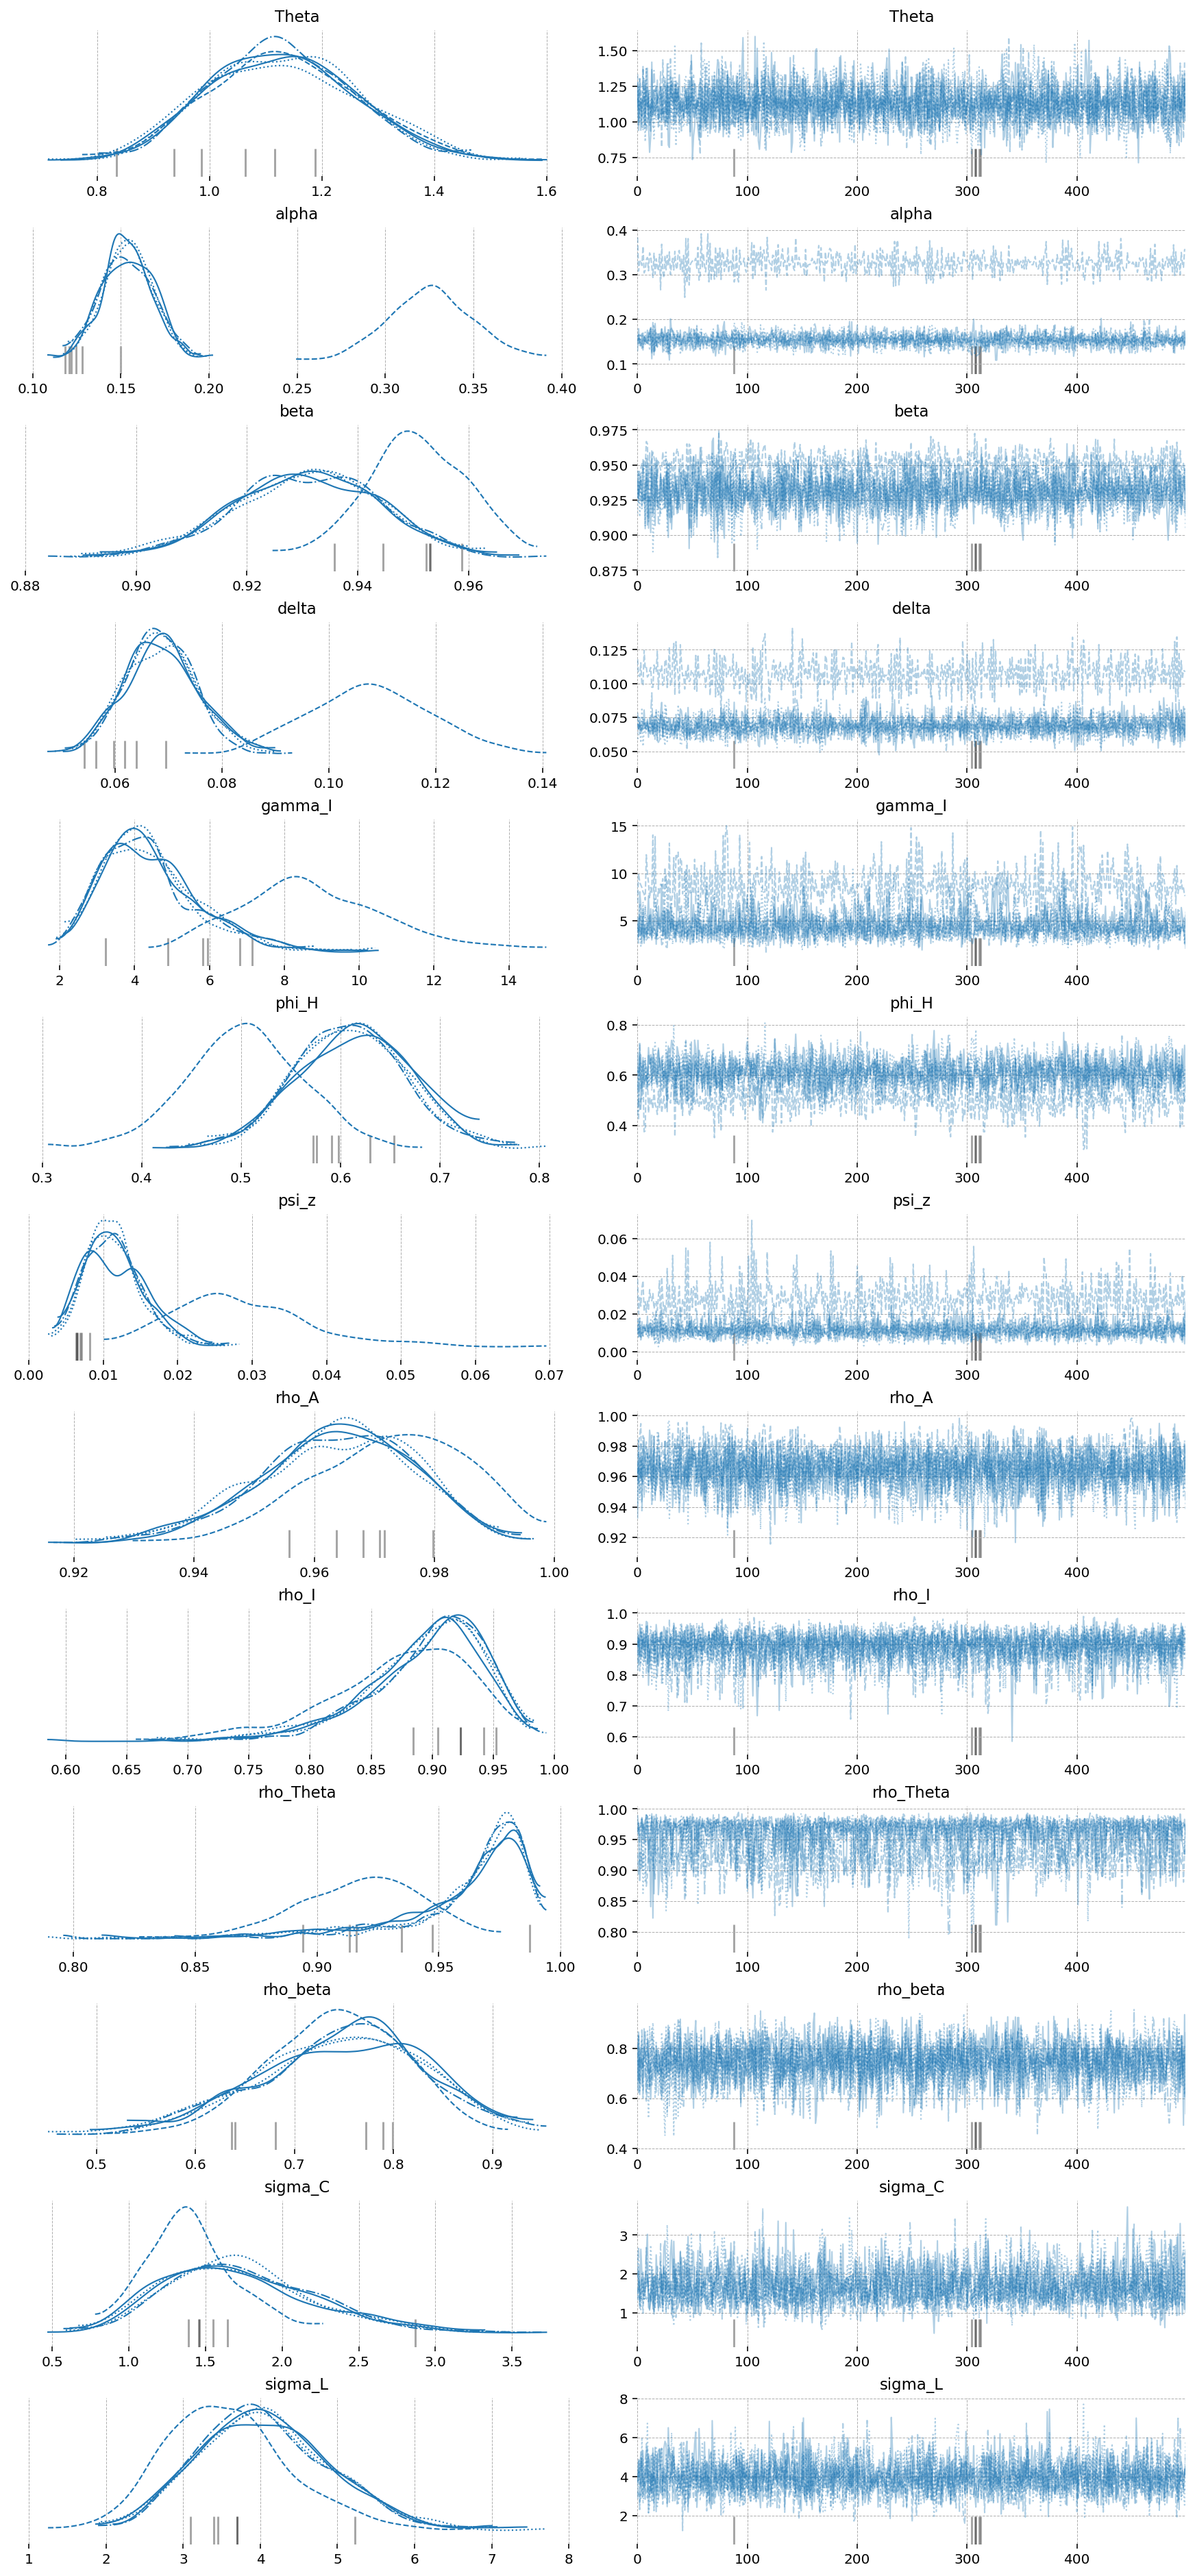

In [38]:
az.plot_trace(idata_extended, var_names=extended_deep_params);

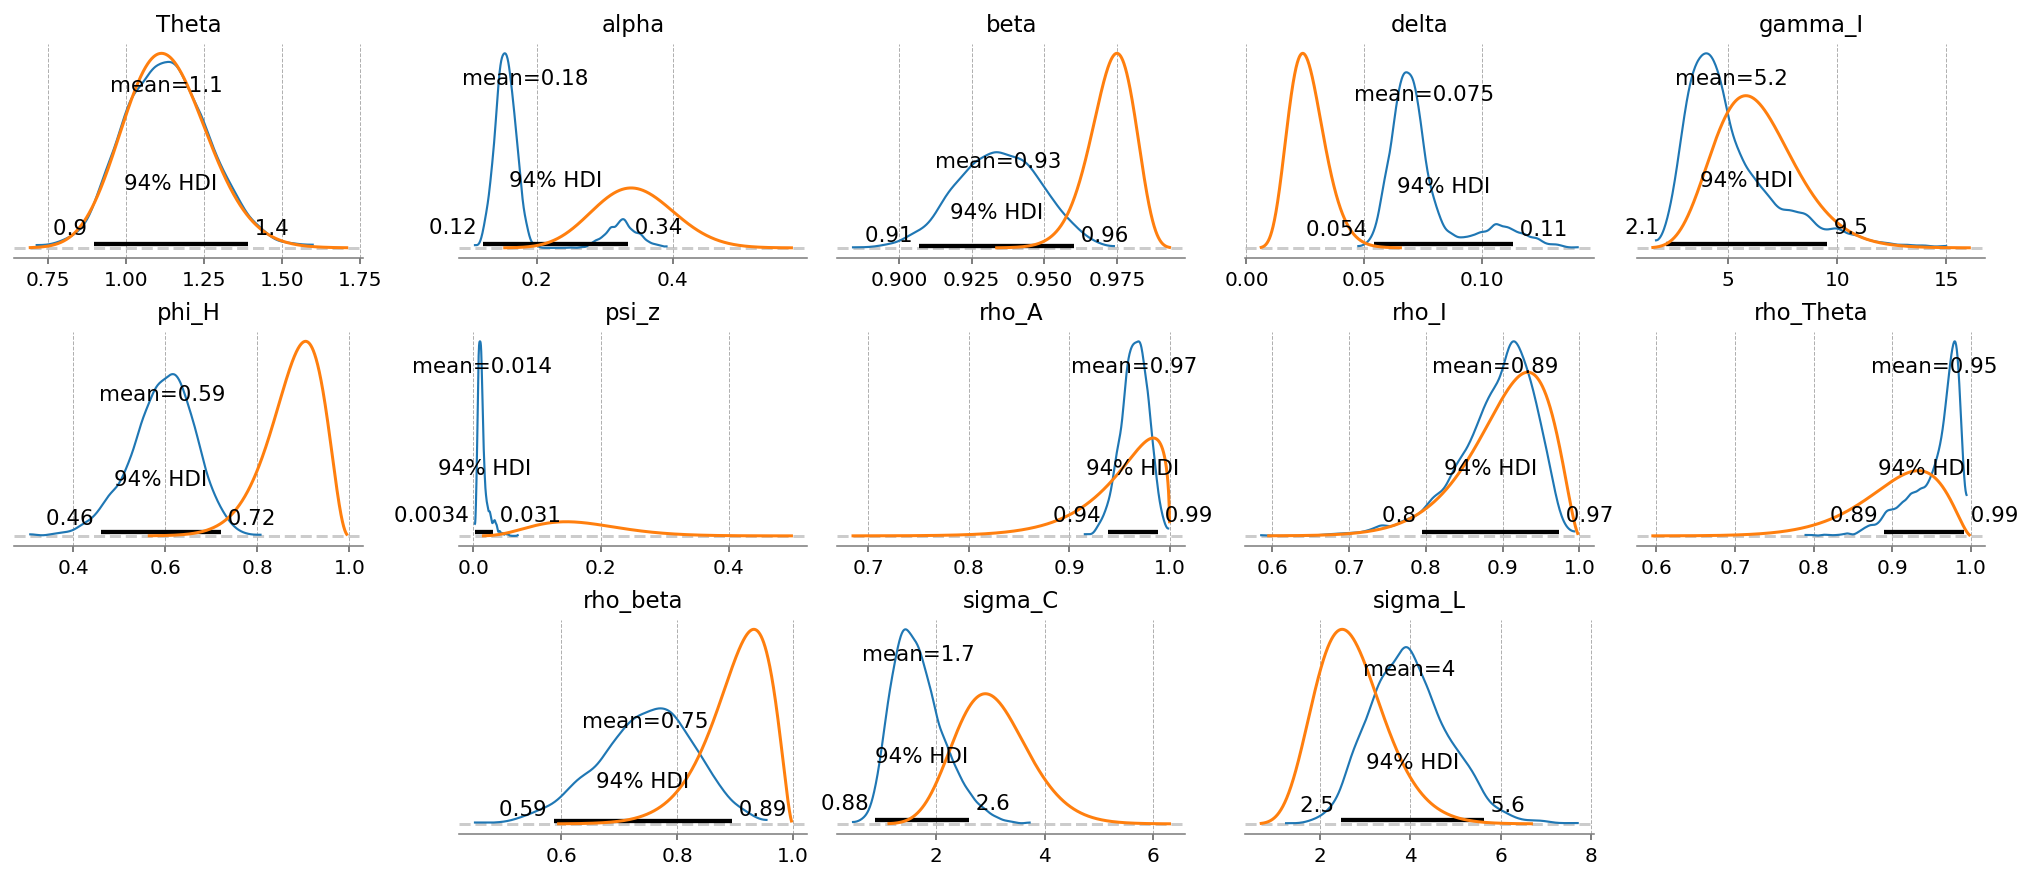

In [39]:
gp.plot_posterior_with_prior(
    idata_extended, var_names=extended_deep_params, prior_dict=prior_dict
);

We can see the sizes of the each type of shock learned by the model, given the data and priors.

Evidently, it felt that the labor dispreference term was the most volatile. Innovations to the time preference are the smallest, followed by TFP. 

Some of this is likely because we put the same prior on eacch term, and the priors were extremely uninformative. Notice the difference in size between the orange (prior) and blue (posterior)! We also don't make any effort to learn correlations between these shocks.

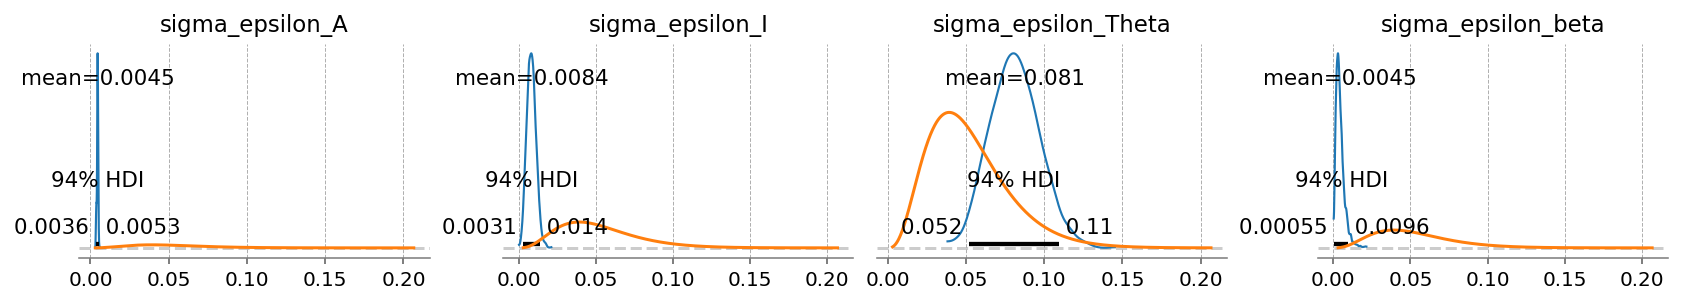

In [40]:
gp.plot_posterior_with_prior(
    idata_extended,
    var_names=extended_shock_params,
    prior_dict=prior_dict,
    fig_kwargs={"figsize": (14, 2)},
);

Checking errors, we see that the model still has no idea what to do with $t$. Aside from that, the other four terms have small errors of similar scale.

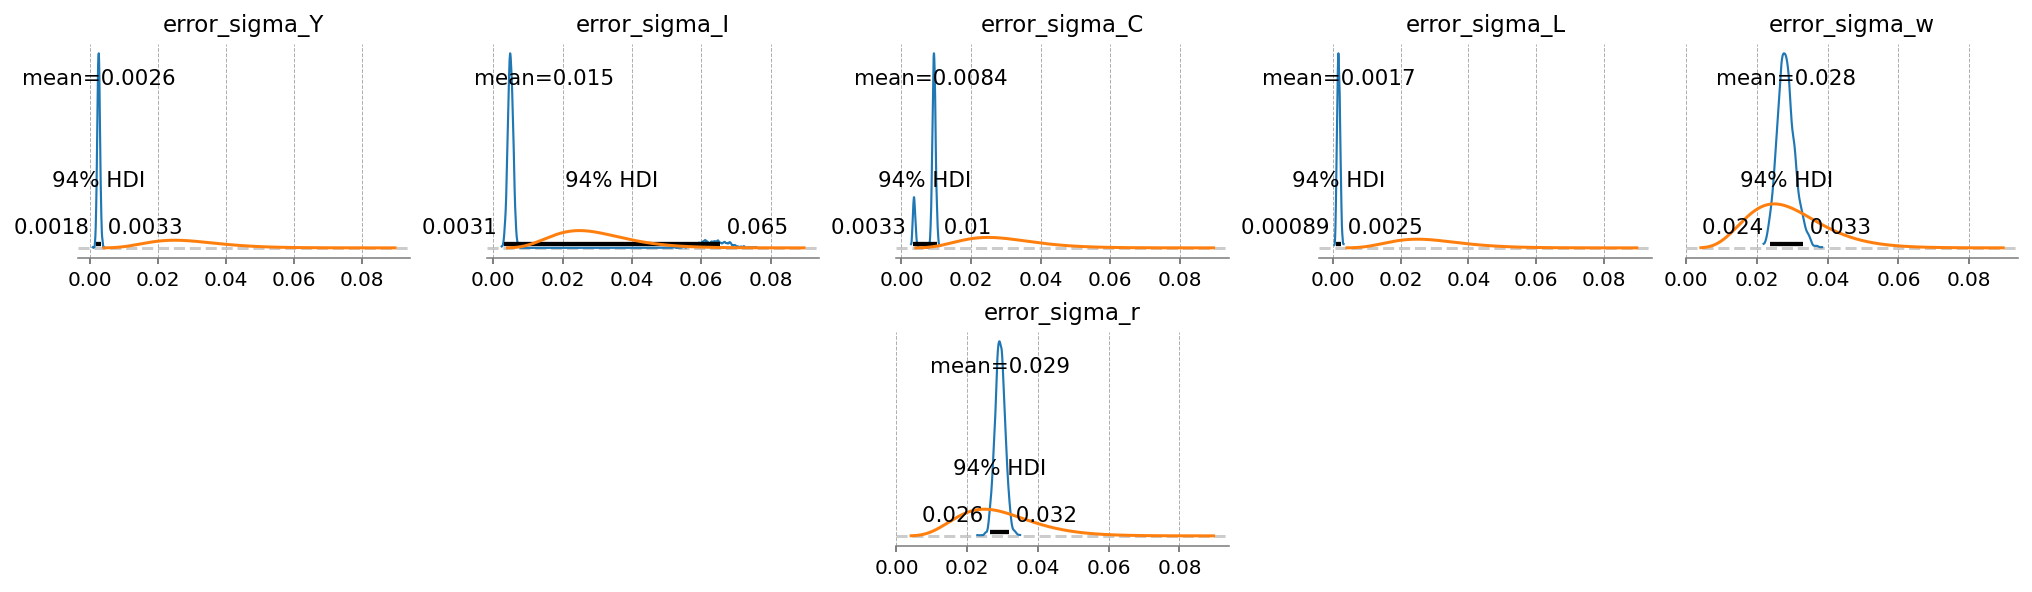

In [41]:
gp.plot_posterior_with_prior(
    idata_extended,
    var_names=extended_error_params,
    prior_dict=prior_dict,
    fig_kwargs={"figsize": (14, 4)},
);

In [42]:
extended_latent_states = ss_mod_extended.sample_conditional_posterior(
    idata_extended, random_seed=rng
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0xCCAC9ACE0>), RNG(<Generator(PCG64) at 0xCCAC9AC00>), RNG(<Generator(PCG64) at 0xCCAC9AB20>), RNG(<Generator(PCG64) at 0xCCAC9AA40>), RNG(<Generator(PCG64) at 0xCCAC9A960>), RNG(<Generator(PCG64) at 0xCCBEE5620>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(


Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

Looking at the observed series, $Y$, $I$, $C$, and $L$ are matched very closely by the filter outputs. $r$ is still hopeless, as is $w$.

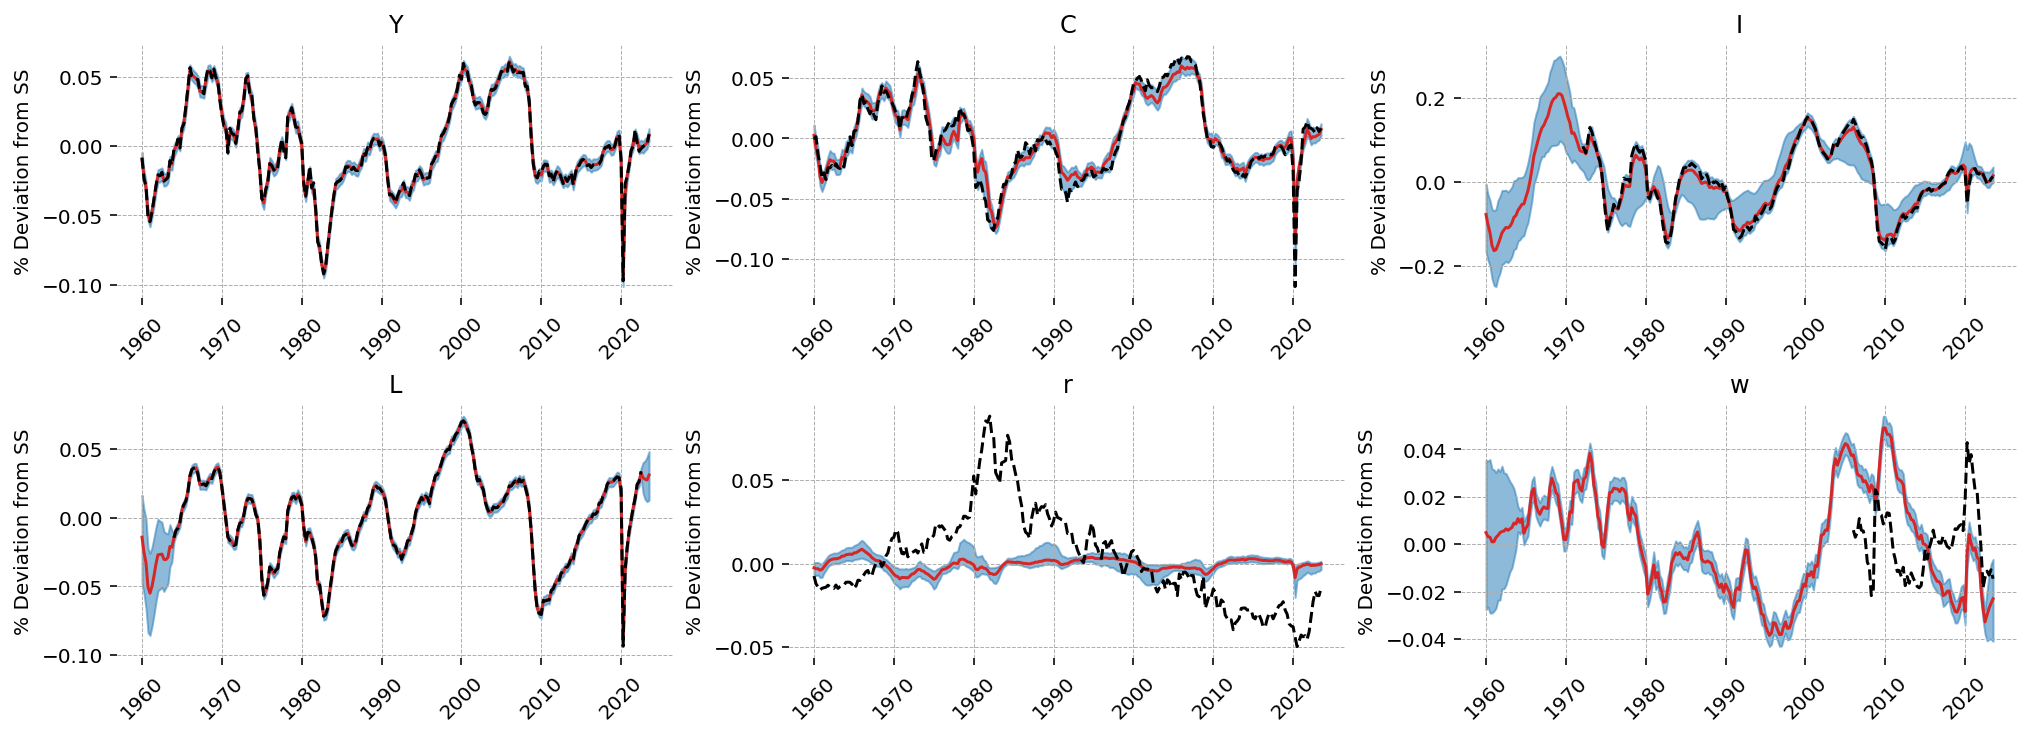

In [43]:
gp.plot_kalman_filter(
    idata=extended_latent_states,
    data=df_detrend,
    kalman_output="smoothed",
    vars_to_plot=["Y", "C", "I", "L", "r", "w"],
    n_cols=3,
    figsize=(14, 5),
);

Looking at the latent shock states, we can see how the model allocated the sources of stochastic variation. Interestingly, TFP shocks ($A$) were used to explain variation in the wage series. The other 3 don't have obvious 1-to-1 allocation, though the investment shock series looks similar to the consumption output.

The high learned variance on the larbor dispreference shock appears to be associated with the COVID dip in the data. In a way that's not so far off -- people certaintly didn't go to work at that time! Though it wasn't because of a change in their preferences: they weren't allowed to!

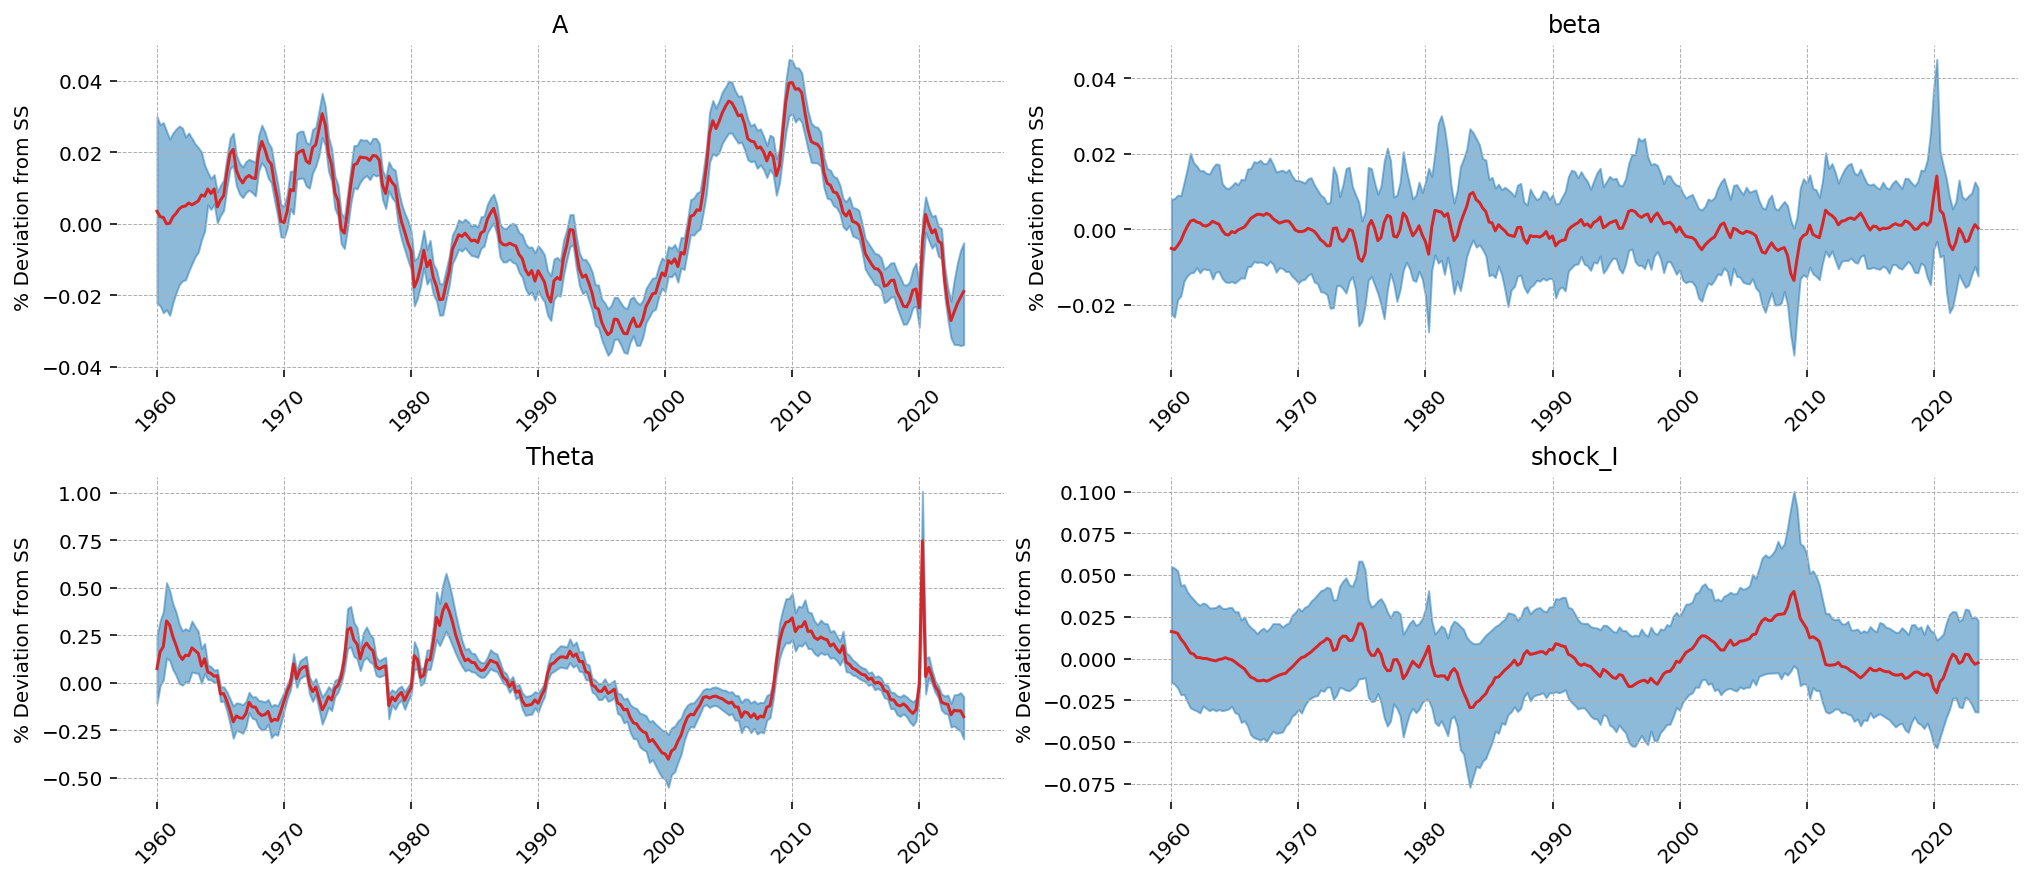

In [44]:
gp.plot_kalman_filter(
    idata=extended_latent_states,
    data=df_detrend,
    kalman_output="smoothed",
    vars_to_plot=["A", "beta", "Theta", "shock_I"],
    n_cols=2,
);

## Forecasts

`PyMCStateSpace` makes it easy to do forecasts -- we just use the `.forecast` method. The data is quarterly, so we can get a 10 year forecast by asking for `periods = 4 * 10 = 40`. By default, it will automatically start at the last date in the data, and it will generate a new `DateTimeIndex` of the same frequency.

I also chose to start the forecasts in 2022Q3, because we don't have labor data after that. So we will also get a sense of how the forecasts do for a year by looking at the difference between the forecast and the data for the national accounts variables (Y, C, I).

In [45]:
forecast = ss_mod_extended.forecast(
    idata_extended, periods=40, start=df_detrend.index[-5]
)

/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)


/Users/jessegrabowski/mambaforge/envs/geconpy-dev/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0xD0A82C660>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


Output()

One interesting this is that the forecasts for capital rental rates are startin out much higher than the data, and wages are much lower. This is an artifact of how the forecasts are generated. We need an initial point to begin forecasting from, and currently we use a kalman filtered state (by default the Smoother output is used). 

Since our estimate of thes price series was so terrible, the initial state for the forecasts doesn't match the data. As a result, we predict a discontinuous jump in the first forecast period. We also see this in wages, but to a lesser extent, in consumption.

For the variables where we have some overlap, we see that the model's HDI captures the economic uptick at the end of the time series, but the mean is flat (for $Y$) or decreasing (for $I$).

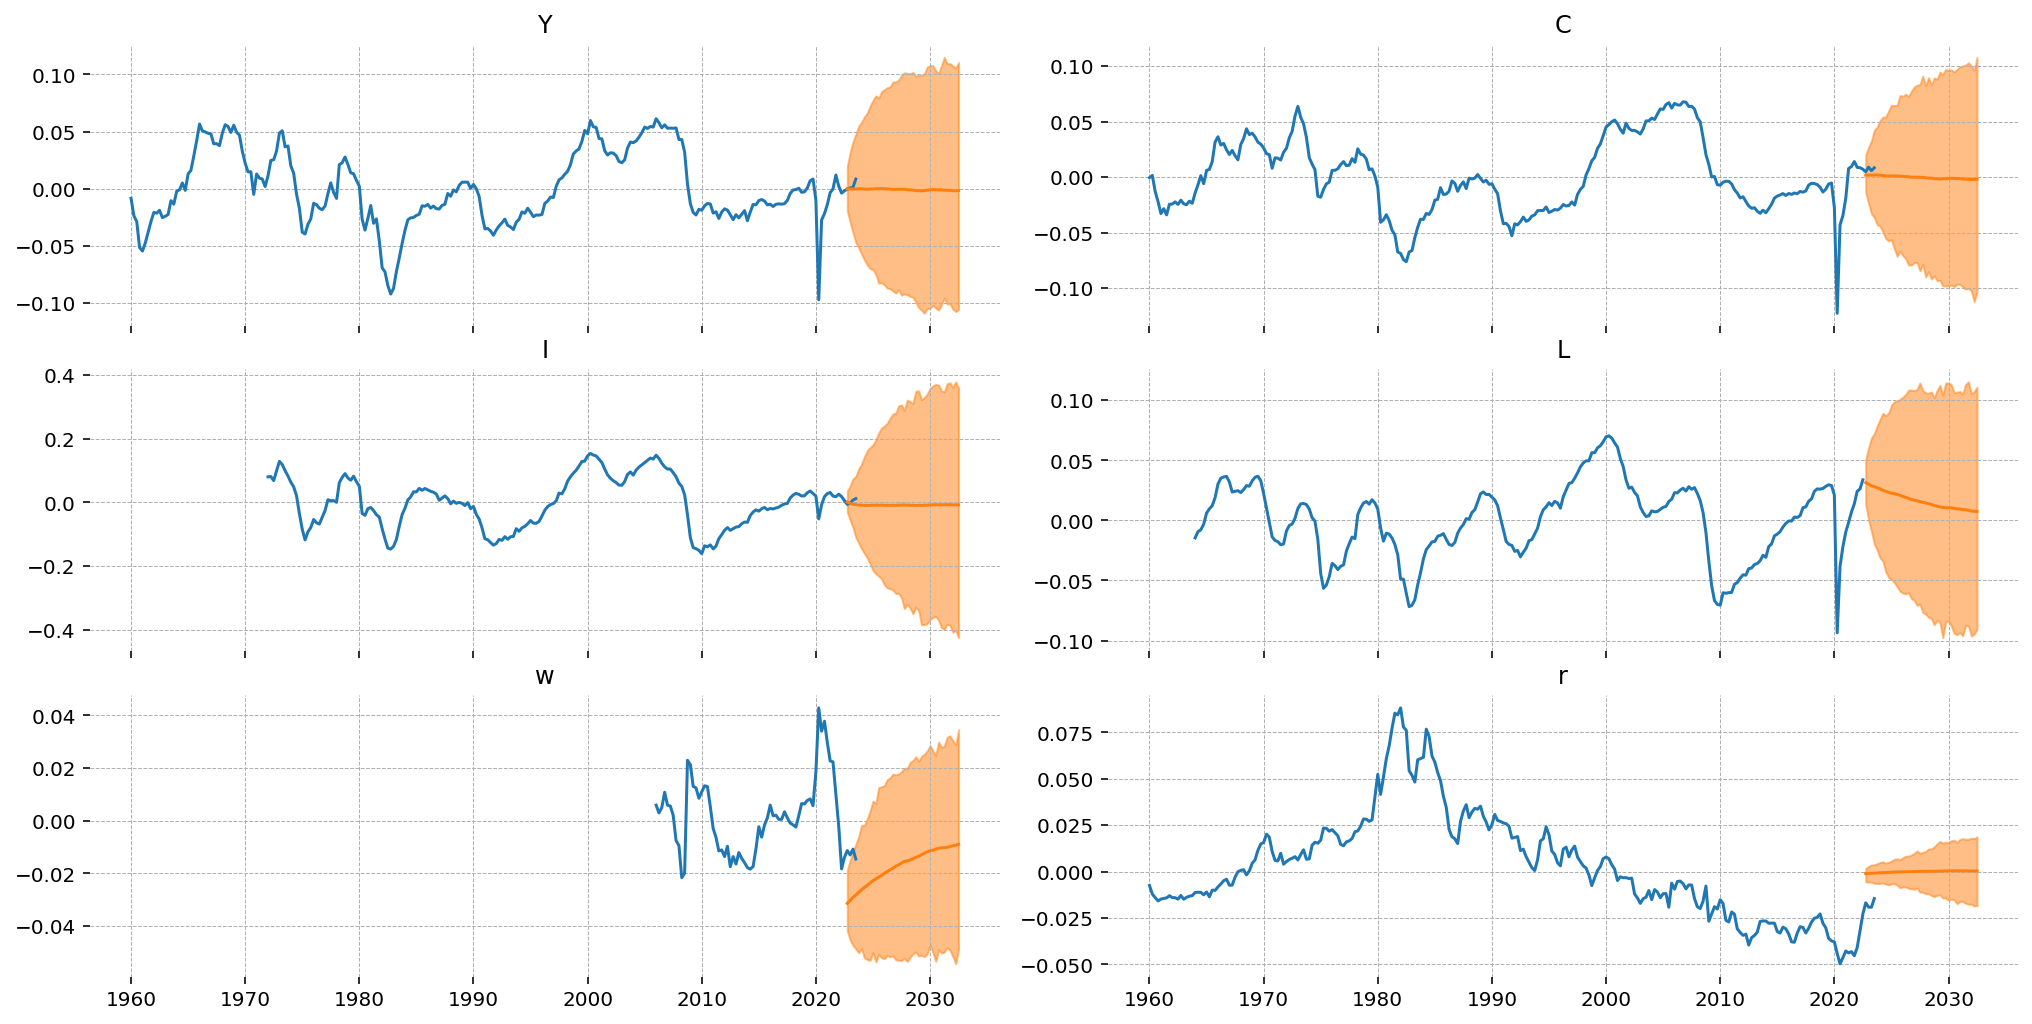

In [46]:
fig, ax = plt.subplots(3, 2, figsize=(14, 7), sharex=True, layout="constrained")

forecast_dates = forecast.coords["time"].values
latent_forecast = forecast.forecast_latent

forecast_mu = latent_forecast.mean(dim=["chain", "draw"])
forecast_hdi = az.hdi(latent_forecast).forecast_latent

for axis, var in zip(fig.axes, ["Y", "C", "I", "L", "w", "r"]):
    obs = df_detrend.loc[:, var]
    axis.plot(obs.index, obs.values)
    axis.plot(forecast_dates, forecast_mu.sel(state=var).values)
    axis.fill_between(
        forecast_dates,
        *forecast_hdi.sel(state=var).values.T,
        color="tab:orange",
        alpha=0.5,
    )
    axis.set_title(var)
plt.show()

Most resources will suggest that you use some kind of filtering procedure to detrend data before fitting a DSGE, for example an HP filter. One advantage of the simple OLS procedure used here is that it can be extended into the future, so we can "re-trend" our forecasts. This is done by reversing the steps on a per-sample basis. In particular we need to:

1. Add back in the mean and linear trend
2. Undo the log with exp

In [47]:
X = np.c_[
    np.ones(df.shape[0] + 40),
    np.arange(df.shape[0] + 40),
    np.arange(df.shape[0] + 40) ** 2,
]
X_forecast = X[-40:]

In [48]:
import xarray as xr

retrended_forecast = latent_forecast.copy()
trends = xr.DataArray(
    np.stack([X_forecast @ beta for beta in betas.values()], axis=1),
    dims=["time", "state"],
    coords={"time": latent_forecast.time.values, "state": list(betas.keys())},
)

retrended_forecast = retrended_forecast + trends
retrended_forecast.loc[:, :, :, ["Y", "C", "I", "L", "w"]] = np.exp(
    retrended_forecast.loc[:, :, :, ["Y", "C", "I", "L", "w"]]
)
retrended_forecast.loc[:, :, :, ["r"]] = retrended_forecast.loc[:, :, :, ["r"]]

Results are plotted in the next cell. Because we undid the detrending sample-wise, we end up with valid probability  distributions over the re-trended data. These forecasts are now dominated by the trend term, which is admittedly not ideal. 

To make this procedure more believable, the quadratic deterministic trend model could be switched out for something with better forecasting properties. For example, one could first estimate an ETS model, use that model's output to detrend the data, then add together the forecasts of both models. This would have the added benefit of combining uncertainty from the underlying trend and the DSGE dynamics. We leave this as an exercise for the motivated reader :)

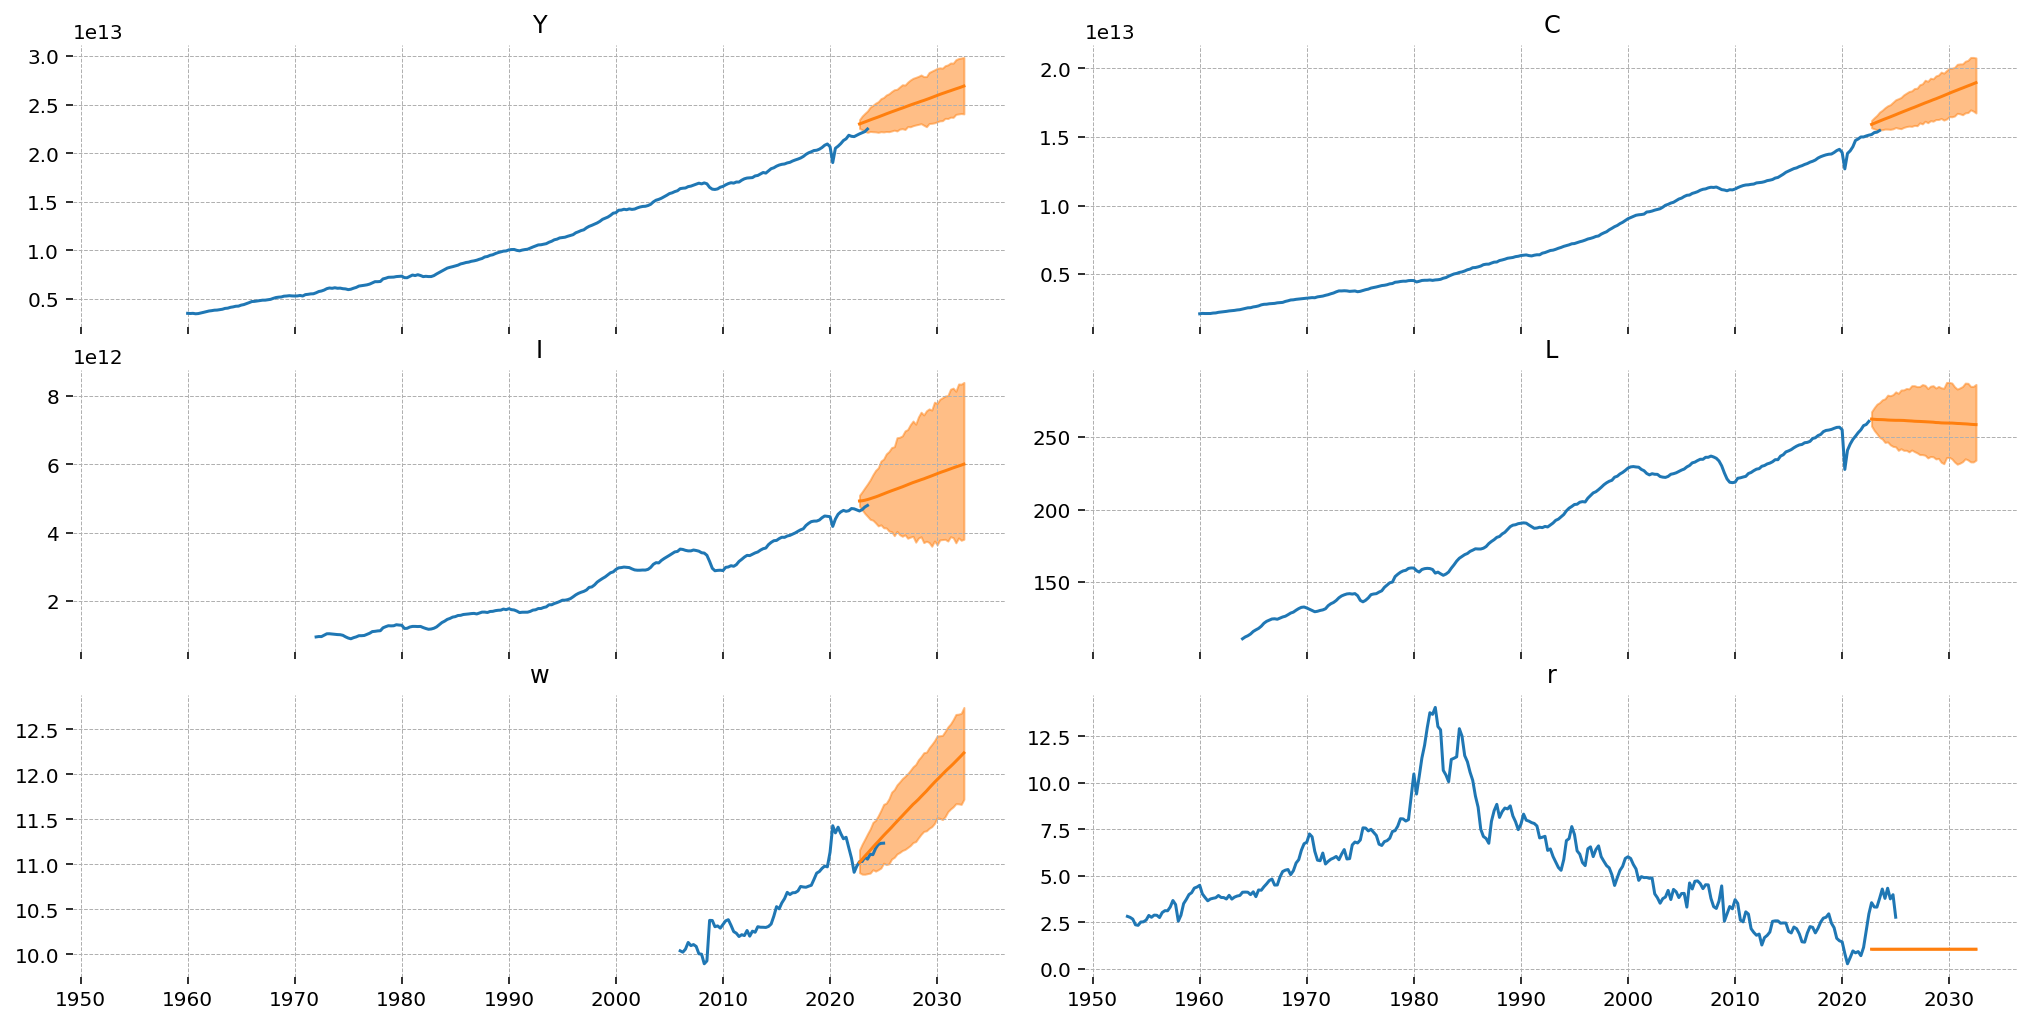

In [49]:
fig, ax = plt.subplots(3, 2, figsize=(14, 7), sharex=True, layout="constrained")

forecast_mu = retrended_forecast.mean(dim=["chain", "draw"])
forecast_hdi = az.hdi(retrended_forecast).x

for axis, var in zip(fig.axes, ["Y", "C", "I", "L", "w", "r"]):
    obs = df.loc[:, var]
    axis.plot(obs.index, obs.values)
    axis.plot(forecast_dates, forecast_mu.sel(state=var).values)
    axis.fill_between(
        forecast_dates,
        *forecast_hdi.sel(state=var).values.T,
        color="tab:orange",
        alpha=0.5,
    )
    axis.set_title(var)
plt.show()

# Authors

- Created by Jesse Grabowski, March 4, 2025

# Watermark

In [50]:
%load_ext watermark
%watermark -n -u -v -iv -m -w

Last updated: Sat Mar 15 2025

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.1

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

xarray           : 2025.1.2
matplotlib       : 3.10.1
numpy            : 1.26.4
arviz            : 0.20.0
pandas_datareader: 0.10.0
pandas           : 2.2.3
preliz           : 0.15.0
gEconpy          : 0+untagged.305.gd931e48.dirty
pymc             : 5.21.1
nutpie           : 0.14.0

Watermark: 2.5.0

